# PSYC 221 Final Project - Code
Title: Determining Neural Regions’ of Interest Relationship to Cognitive Impairment Symptoms Using Tau Scans

Authors: Ardo Nashalian, Carlos Ayala Bellido, Kyan Younes

## Library Imports

In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn import metrics # Metrics for classification
from statsmodels.stats import contingency_tables # Contringency tables
import torch # PyTorch
from torch import nn # Modules and layers
from torch.utils.data import Dataset # PyTorch dataset
from torch.utils.data import DataLoader # PyTorch Dataloader
from sklearn.model_selection import KFold, cross_val_score
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn import metrics
from google.colab import drive
from sklearn.metrics import r2_score
drive.mount('/content/drive')
np.random.seed(0)
torch.manual_seed(0)

Mounted at /content/drive


## Multi-output Support Vector Regression

Defining all the functions used throughout the program

In [2]:
"""
Multi-output Support Vector Regression
"""
# Copyright (C) 2020 Xinze Zhang, Kaishuai Xu, Siyue Yang, Yukun Bao
# <xinze@hust.edu.cn>, <xu.kaishuai@gmail.com>, <siyue_yang@hust.edu.cn>, <yukunbao@hust.edu.cn>

# This program is free software: you can redistribute it and/or modify
# it under the terms of the Apache.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# Apache License for more details.



import numpy as np
from sklearn.metrics.pairwise import pairwise_kernels

class MSVR():
    def __init__(self, kernel='rbf', degree=3, gamma=None, coef0=0.0, tol=0.001, C=1.0, epsilon=0.1):
        super(MSVR, self).__init__()
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.coef0 = coef0
        self.tol = tol
        self.C = C
        self.epsilon = epsilon
        self.Beta = None
        self.NSV = None
        self.xTrain = None

    def fit(self, x, y):
        self.xTrain = x.copy()
        C = self.C
        epsi = self.epsilon
        tol = self.tol

        n_m = np.shape(x)[0]  # num of samples
        n_d = np.shape(x)[1]  # input data dimensionality
        n_k = np.shape(y)[1]  # output data dimensionality (output variables)

        # H = kernelmatrix(ker, x, x, par)
        H = pairwise_kernels(x, x, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)

        self.Beta = np.zeros((n_m, n_k))

        #E = prediction error per output (n_m * n_k)
        E = y - np.dot(H, self.Beta)
        #RSE
        u = np.sqrt(np.sum(E**2, 1, keepdims=True))

        #RMSE
        RMSE = []
        RMSE_0 = np.sqrt(np.mean(u**2))
        RMSE.append(RMSE_0)

        #points for which prediction error is larger than epsilon
        i1 = np.where(u > epsi)[0]

        #set initial values of alphas a (n_m * 1)
        a = 2 * C * (u - epsi) / u

        #L (n_m * 1)
        L = np.zeros(u.shape)

        # we modify only entries for which  u > epsi. with the sq slack
        L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

        #Lp is the quantity to minimize (sq norm of parameters + slacks)
        Lp = []
        BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
        Lp_0 = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
        Lp.append(Lp_0)

        eta = 1
        k = 1
        hacer = 1
        val = 1

        while(hacer):
            Beta_a = self.Beta.copy()
            E_a = E.copy()
            u_a = u.copy()
            i1_a = i1.copy()

            M1 = H[i1][:, i1] + \
                np.diagflat(1/a[i1]) + 1e-10 * np.eye(len(a[i1]))

            #compute betas
            #       sal1 = np.dot(np.linalg.pinv(M1),y[i1])  #求逆or广义逆（M-P逆）无法保证M1一定是可逆的？
            sal1 = np.dot(np.linalg.inv(M1), y[i1])

            eta = 1
            self.Beta = np.zeros(self.Beta.shape)
            self.Beta[i1] = sal1.copy()

            #error
            E = y - np.dot(H, self.Beta)
            #RSE
            u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)
            i1 = np.where(u >= epsi)[0]

            L = np.zeros(u.shape)
            L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2

            #%recompute the loss function
            BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
            Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
            Lp.append(Lp_k)

            #Loop where we keep alphas and modify betas
            while(Lp[k] > Lp[k-1]):
                eta = eta/10
                i1 = i1_a.copy()

                self.Beta = np.zeros(self.Beta.shape)
                #%the new betas are a combination of the current (sal1)
                #and of the previous iteration (Beta_a)
                self.Beta[i1] = eta*sal1 + (1-eta)*Beta_a[i1]

                E = y - np.dot(H, self.Beta)
                u = np.sqrt(np.sum(E**2, 1)).reshape(n_m, 1)

                i1 = np.where(u >= epsi)[0]

                L = np.zeros(u.shape)
                L[i1] = u[i1]**2 - 2 * epsi * u[i1] + epsi**2
                BetaH = np.dot(np.dot(self.Beta.T, H), self.Beta)
                Lp_k = np.sum(np.diag(BetaH), 0) / 2 + C * np.sum(L)/2
                Lp[k] = Lp_k

                #stopping criterion 1
                if(eta < 1e-16):
                    Lp[k] = Lp[k-1] - 1e-15
                    self.Beta = Beta_a.copy()

                    u = u_a.copy()
                    i1 = i1_a.copy()

                    hacer = 0

            #here we modify the alphas and keep betas
            a_a = a.copy()
            a = 2 * C * (u - epsi) / u

            RMSE_k = np.sqrt(np.mean(u**2))
            RMSE.append(RMSE_k)

            if((Lp[k-1]-Lp[k])/Lp[k-1] < tol):
                hacer = 0

            k = k + 1

            #stopping criterion #algorithm does not converge. (val = -1)
            if(len(i1) == 0):
                hacer = 0
                self.Beta = np.zeros(self.Beta.shape)
                val = -1

        self.NSV = len(i1)

    def predict(self, x):
        H = pairwise_kernels(x, self.xTrain, metric=self.kernel, filter_params=True,
                             degree=self.degree, gamma=self.gamma, coef0=self.coef0)
        yPred = np.dot(H, self.Beta)
        return yPred

    # def score(self,x):

In [3]:
import numpy as np
from numpy import concatenate

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# import statistics

def create_dataset(ts, dim ,h):
    look_back = dim + h -1
    # dataset = np.insert(dataset, [0] * look_back, 0)
    dataX, dataY = [], []
    for i in range(len(ts) - look_back):
        a = ts[i:(i + look_back)]
        dataX.append(a)
        dataY.append(ts[i + look_back])
    dataY = np.array(dataY)
    dataY = np.reshape(dataY, (dataY.shape[0], 1))
    dataset = np.concatenate((dataX, dataY), axis=1)
    return dataset


def unpadding(y):
    a = y.copy()
    h = y.shape[1]
    s = np.empty(y.shape[0] + y.shape[1] -1)

    for i in range(s.shape[0]):
        s[i]=np.diagonal(np.flip(a,1), offset= -i + h-1,axis1=0,axis2=1).copy().mean()

    return s

def mape(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true):
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/y_true[mask]
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

    return metric

def smape(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    mask =  y_true != 0.0
    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true):
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)
    N_metric =  (y_true[mask] - y_pred[mask])/(y_true[mask] + y_pred[mask])
    N_metric = np.fabs(N_metric)
    metric = N_metric.mean()

def rmse(y_true, y_pred):
    y_true = unpadding(y_true)
    y_pred = unpadding(y_pred)

    return np.sqrt(mean_squared_error(y_true,y_pred))

In [4]:
class PandasDataset(Dataset):
    def __init__(self, df, feature_cols, target_col, y_dtype=torch.int64):
        self.X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
# Build a classifier in PyTorch
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size=None, nr_classes=4, hidden_layer_sizes=[16,8], save_path="models"):
        super().__init__()
        self.name = self.__class__.__name__ + '-'.join([str(n) for n in hidden_layer_sizes])
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Define the architecture of the model
        layers = []
        nr_neurons = [input_size] + hidden_layer_sizes
        for ix in range(len(nr_neurons)-1):
            # A linear, fully-connected layer
            layers.append(nn.Linear(nr_neurons[ix], nr_neurons[ix+1]))
            # A ReLU activation function
            layers.append(nn.ReLU())
        # Final layer, in this (nr_classes==6) classification
        layers.append(nn.Linear(nr_neurons[-1], nr_classes))
        # Finally, we place them one after the other
        self.layers = nn.Sequential(*layers)
        # The softmax function ensures we have one output per class, and these add up to 1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''Forward pass'''
        # x = self.flatten(x)
        logits = self.layers(x)
        return logits

    def predict(self, X):
        '''Make a prediction based on a given input'''
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return int(pred.argmax().detach())

    def save(self, state_name='last', verbose=False):
        '''Saves a model state in the defined path, with the model name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        torch.save(self.state_dict(), os.path.join(self.save_path, model_state_name))
        if verbose:
            print("Saved PyTorch model state {} in {}".format(model_state_name, self.save_path))

    def restore(self, state_name):
        '''Restores a model state for the given state name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        self.load_state_dict(torch.load(os.path.join(self.save_path, model_state_name)))

In [6]:
# Methods to train and evaluate model
def train_model(model, train_dl, optimizer, loss_f, nr_epochs, print_loss_every=10):
    for t in range(nr_epochs):
        model.train()
        nr_batches = len(train_dl)
        total_loss = 0
        optimizer.zero_grad()
        for _, (X, y) in enumerate(train_dl):
            # Backpropagation step
            pred = model(X)
            loss = loss_f(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        if t % print_loss_every == 0:
            print(f"Epoch {t} loss {total_loss / nr_batches}")
    model.save()
    print("Finished training!")

def eval_model(model, dl):
    model.eval() # This is important for certain stochastic elements, such as MC Dropout
    targets = []
    predictions = []
    for X, y in dl:
        pred = model(X)
        targets += list(y.detach().cpu().numpy())
        predictions += list(pred.detach().cpu().numpy())
    plt.figure()
    plt.scatter(targets,predictions)
    plt.plot(targets,targets)
    plt.xlabel('True PHC')
    plt.ylabel('Predicted PHC')
    MAE = metrics.mean_squared_error(targets, predictions)
    R2 = r2_score(targets,predictions)
    plt.figure()
    plt.hist(targets)
    return (MAE,R2)
    print(f"Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy}")

In [7]:
class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(112, 4)
        self.act = nn.ReLU()
        self.output = nn.Linear(112, 4)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

model = Multiclass()

Import Data/Zscore

In [8]:
DataPath = '/content/drive/Shareddrives/PSYC 221 /ADNI_Tau_PHC.xlsx'
target_cols = ['','','','']
df = pd.read_excel(DataPath)
train_ds = df.sample(frac = 0.80)
test_ds = df.drop(train_ds.index)
input_size =112
out_columns = df.columns.str.contains('PHC')
feature_columns = df.columns.str.contains('_SUVR')
features_train = train_ds[train_ds.columns[feature_columns]]
features_train = stats.zscore(features_train)
features_train = features_train.dropna(axis=1)
features_test = test_ds[test_ds.columns[feature_columns]]
features_test = features_test.drop(columns=['INFERIORCEREBELLUM_SUVR'])
features_test = features_test.dropna(axis=1)
out_train = train_ds[train_ds.columns[out_columns]]
out_train = out_train.fillna(0)
out_train = stats.zscore(out_train)
out_test = test_ds[test_ds.columns[out_columns]]
out_test = out_test.fillna(0)
target_cols = [col for col in out_train.columns]
feature_cols = [col for col in features_train.columns]
train_ds = pd.concat([features_train,out_train],axis=1)
train_ds.head()

,ERODED_SUBCORTICALWM_SUVR,BRAAK1_SUVR,BRAAK34_SUVR,META_TEMPORAL_SUVR,BRAAK56_SUVR,BRAINSTEM_SUVR,VENTRICLE_3RD_SUVR,VENTRICLE_4TH_SUVR,CC_ANTERIOR_SUVR,CC_CENTRAL_SUVR,...,RIGHT_LATERAL_VENTRICLE_SUVR,RIGHT_PALLIDUM_SUVR,RIGHT_PUTAMEN_SUVR,RIGHT_THALAMUS_PROPER_SUVR,RIGHT_VENTRALDC_SUVR,WM_HYPOINTENSITIES_SUVR,PHC_MEM_mannualJoin,PHC_EXF_mannualJoin,PHC_LAN_mannualJoin,PHC_VSP_mannualJoin
55,-1.079803,-0.809630,-0.884023,-0.791517,-0.738504,0.028151,-0.141303,0.478843,-0.092070,-1.701819,...,0.002184,-0.215278,-0.699792,-1.110506,-0.947722,-0.530967,-0.405100,-0.579796,-1.712534,-0.011907
316,0.917224,0.410145,0.423597,0.252857,0.204810,1.232406,1.544558,0.791386,1.649710,1.250913,...,1.590671,0.667413,0.854783,0.883848,0.688876,1.766617,1.372322,1.861367,3.019285,0.884147
252,2.292750,1.720766,1.465137,1.195472,1.543172,1.530273,0.829861,-0.309353,0.999451,2.481615,...,0.860794,1.724445,1.821885,1.665109,2.216308,1.841643,-1.508571,-1.001975,-1.963313,-0.263073
262,-0.001906,-0.275875,-0.216529,-0.206245,-0.050029,-0.138280,-0.251108,0.910335,-0.276814,0.432775,...,0.509547,-0.457832,-0.608828,-0.001033,-0.182854,-0.451654,-0.088612,0.713226,0.191413,-1.311863
31,-0.632545,-0.506993,-0.468515,-0.437019,-0.454944,-0.628201,0.394675,0.672145,-0.484723,-1.002366,...,0.252627,0.559454,-0.266399,0.520968,0.469099,-0.079622,0.525998,0.090083,-0.237552,-0.011907


#SUVR inputs to PHC Score outputs

NN Implementation of SUVR --> PHC Score

['PHC_MEM_mannualJoin', 'PHC_EXF_mannualJoin', 'PHC_LAN_mannualJoin', 'PHC_VSP_mannualJoin']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.36787789804594856
Epoch 5 loss 0.2943781473806926
Epoch 10 loss 0.27266802745206015
Epoch 15 loss 0.26126111298799515
Epoch 20 loss 0.2508618463362966
Epoch 25 loss 0.2464691341987678
Epoch 30 loss 0.2501557183052812
Epoch 35 loss 0.23361477915729795
Epoch 40 loss 0.23204757922462055
Epoch 45 loss 0.23088601774403028
Epoch 50 loss 0.22580193589840616
Epoch 55 loss 0.22121271746499196
Epoch 60 loss 0.21971108242869378
Epoch 65 loss 0.2178844343338694
Epoch 70 loss 0.22484453405652727
Epoch 75 loss 0.21551840975880623
Epoch 80 loss 0.212546335373606
Epoch 85 loss 0.21543404704758098
Epoch 90 loss 0.21002675678048816
Epoch 95 loss 0.20795272482292992
Finished training!
['PH

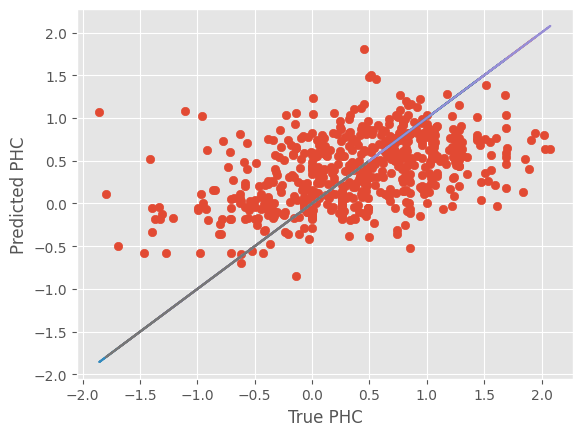

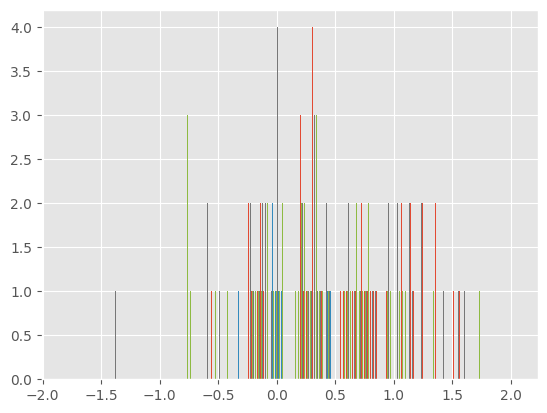

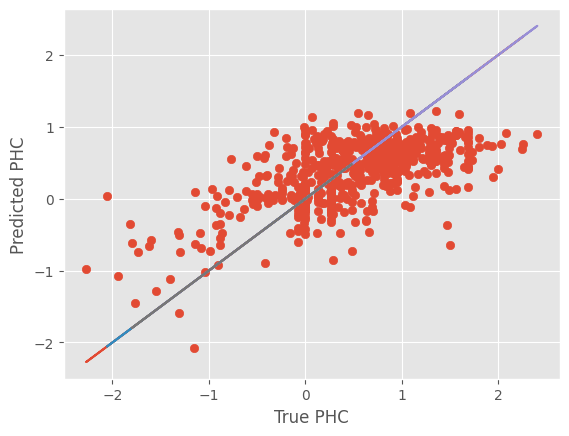

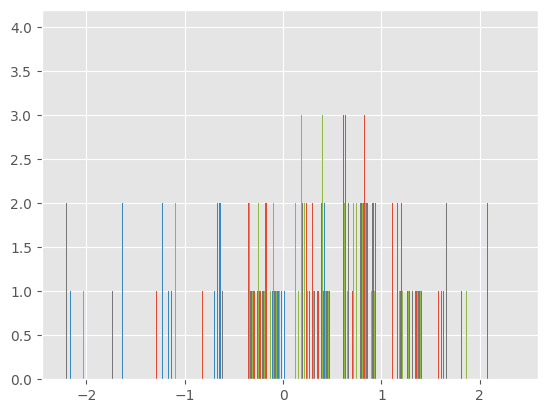

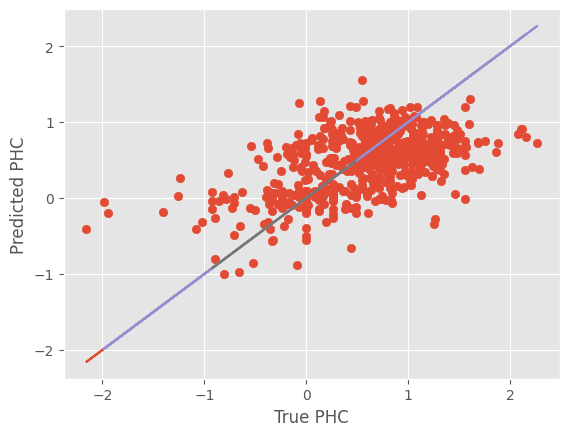

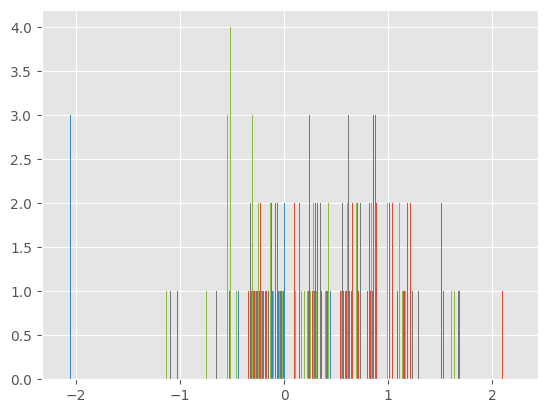

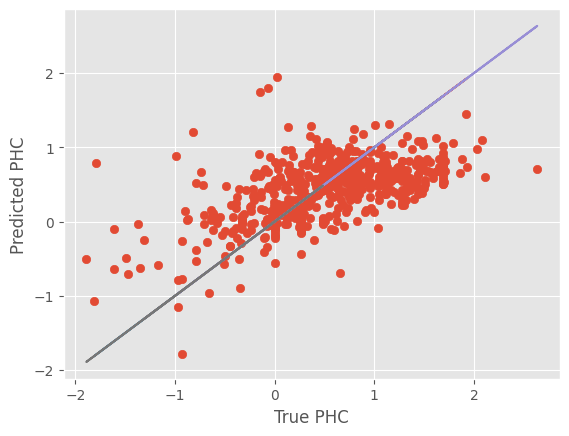

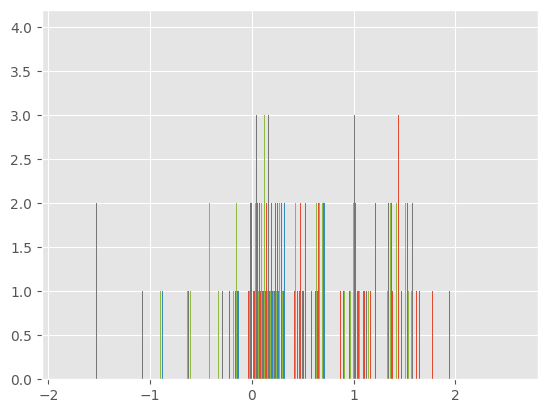

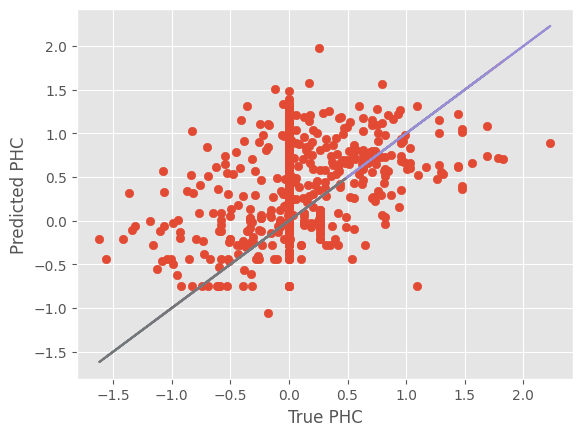

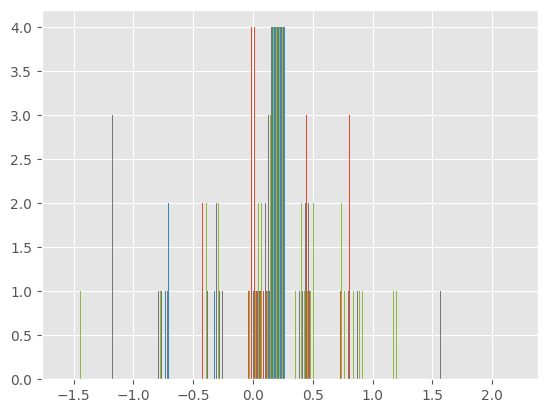

In [12]:
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df = df.drop(columns=['INFERIORCEREBELLUM_SUVR'])
df[feature_cols] = stats.zscore(df[feature_cols])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size =118
  out_columns = df.columns.str.contains('PHC')
  feature_columns = df.columns.str.contains('_SUVR')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

In [ ]:
print((R2))

[0.07641877 0.26585589 0.1407615  0.12604384]


SVM Implementation of SUVR-->PHC Scores

In [13]:
import warnings

warnings.filterwarnings("ignore")

0.3545155053677835
-0.06767079459945877
[0.35370405 0.39713174 0.36123016 0.37977278 0.2807388 ]
[ 0.01835057 -0.03054913 -0.1587148   0.03481169 -0.2022523 ]


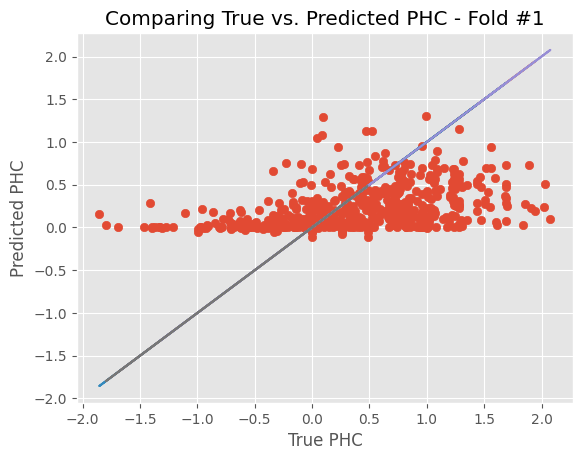

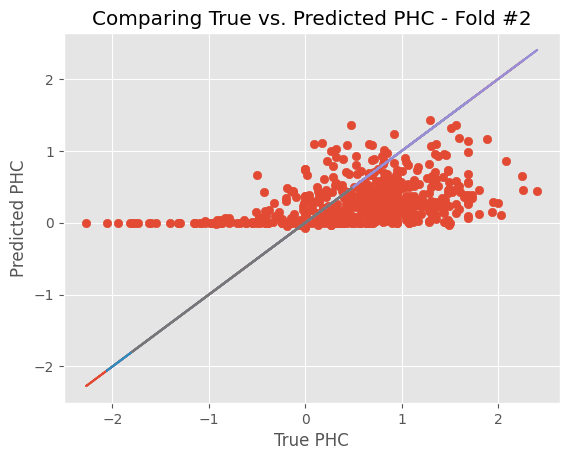

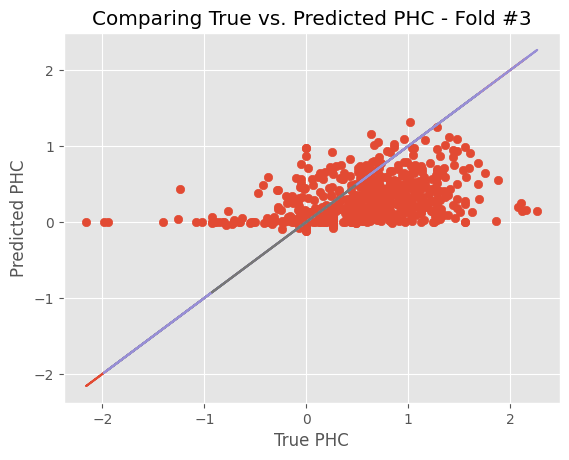

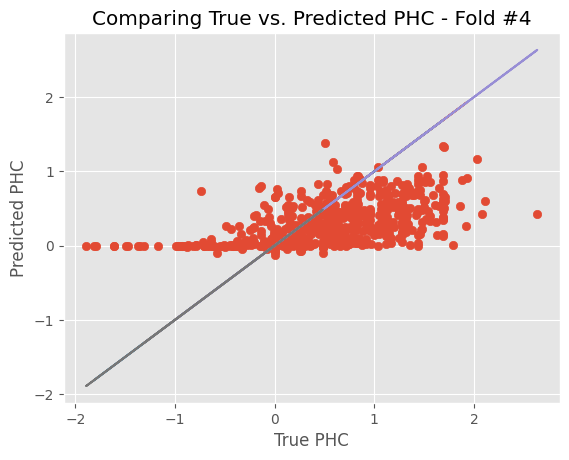

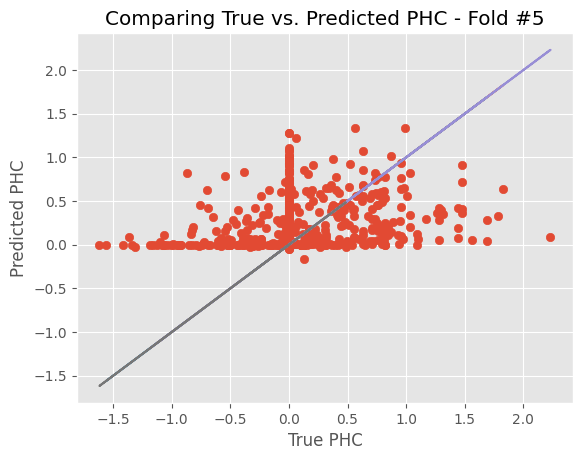

In [14]:
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  out_columns = df.columns.str.contains('PHC')
  feature_columns = df.columns.str.contains('_SUVR')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  R2[i] = r2_score(out_test,testPred)
  RMSE_SVM[i]= rmse(out_test,testPred)
  plt.figure ()
  plt.plot(out_test,out_test)
  plt.scatter(out_test,testPred)
  plt.xlabel("True PHC")
  plt.ylabel("Predicted PHC")
  fold_num = i+1
  plt.title("Comparing True vs. Predicted PHC - Fold #" + str(fold_num))
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(RMSE_SVM)
print(R2)

#Fully Connected ROI Volume To SUVR Scores
ROI Volume inputs to SUVR outputs

ROI to SUVR In a fully connected Manner but later discovered this was not a good implementation.

New Neural Network implementation for this application

In [ ]:
# Build a classifier in PyTorch
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size=None, nr_classes=119, hidden_layer_sizes=[16,8], save_path="models"):
        super().__init__()
        self.name = self.__class__.__name__ + '-'.join([str(n) for n in hidden_layer_sizes])
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Define the architecture of the model
        layers = []
        nr_neurons = [input_size] + hidden_layer_sizes
        for ix in range(len(nr_neurons)-1):
            # A linear, fully-connected layer
            layers.append(nn.Linear(nr_neurons[ix], nr_neurons[ix+1]))
            # A ReLU activation function
            layers.append(nn.ReLU())
        # Final layer, in this (nr_classes==6) classification
        layers.append(nn.Linear(nr_neurons[-1], nr_classes))
        # Finally, we place them one after the other
        self.layers = nn.Sequential(*layers)
        # The softmax function ensures we have one output per class, and these add up to 1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''Forward pass'''
        # x = self.flatten(x)
        logits = self.layers(x)
        return logits

    def predict(self, X):
        '''Make a prediction based on a given input'''
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return int(pred.argmax().detach())

    def save(self, state_name='last', verbose=False):
        '''Saves a model state in the defined path, with the model name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        torch.save(self.state_dict(), os.path.join(self.save_path, model_state_name))
        if verbose:
            print("Saved PyTorch model state {} in {}".format(model_state_name, self.save_path))

    def restore(self, state_name):
        '''Restores a model state for the given state name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        self.load_state_dict(torch.load(os.path.join(self.save_path, model_state_name)))

['INFERIORCEREBELLUM_SUVR', 'ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARACENTRAL_SUVR', 'CTX_LH_PARAHIPPOCAMPAL_SUVR', 'CTX_LH_PARSOPERCULARIS_SUVR', 'CTX_LH_PARSORBITALIS_SUVR', 'CTX_LH_PARSTRIANGULARIS_SUVR', 'CTX_LH_PERICALCARINE_SUVR', 'CTX_LH_POSTCENTRAL

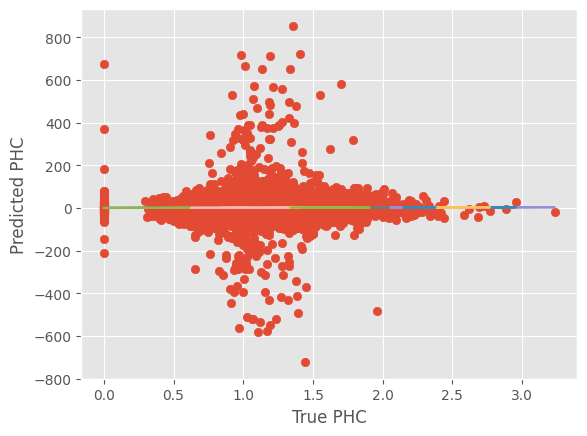

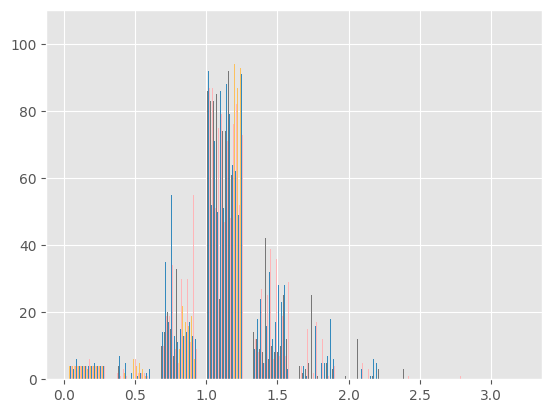

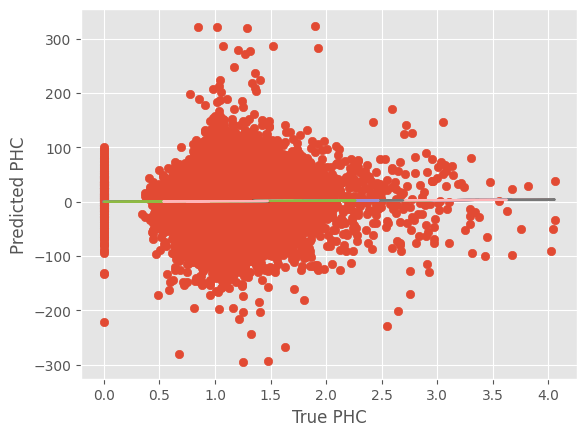

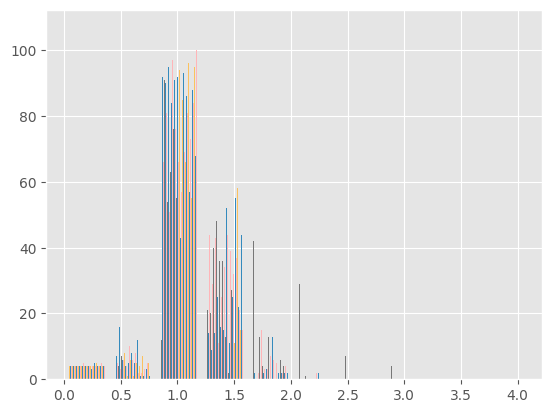

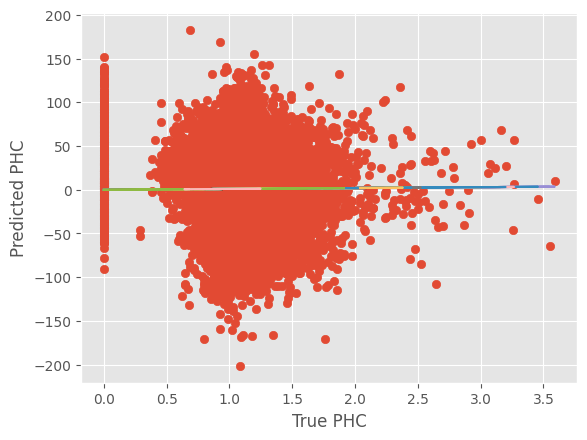

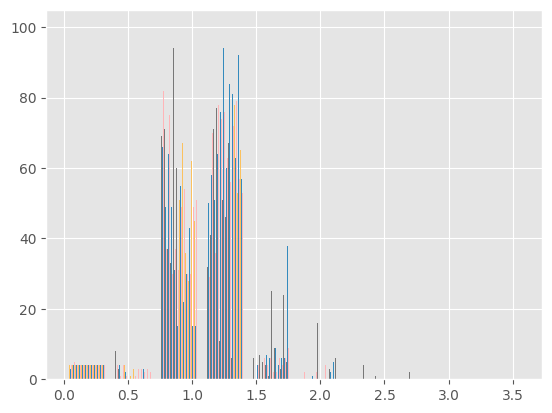

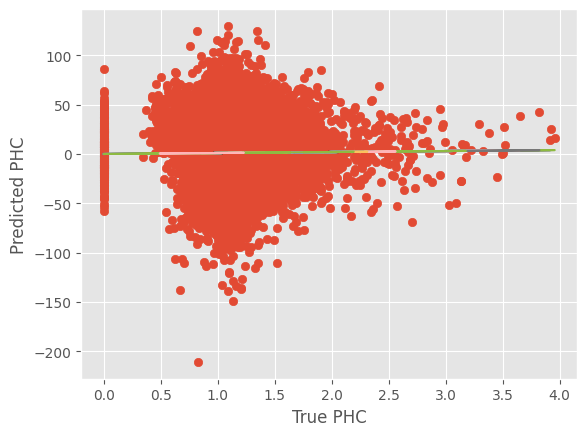

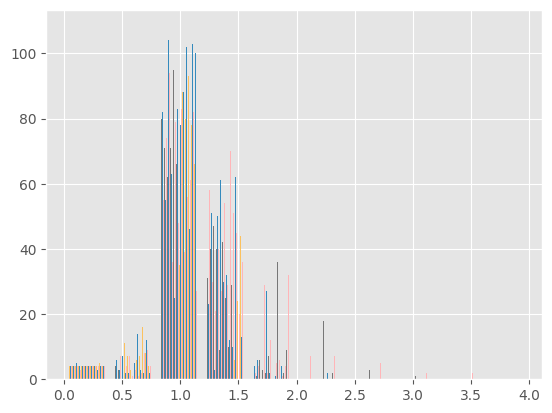

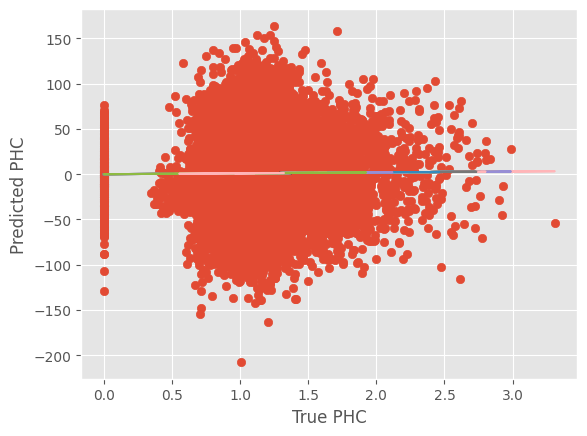

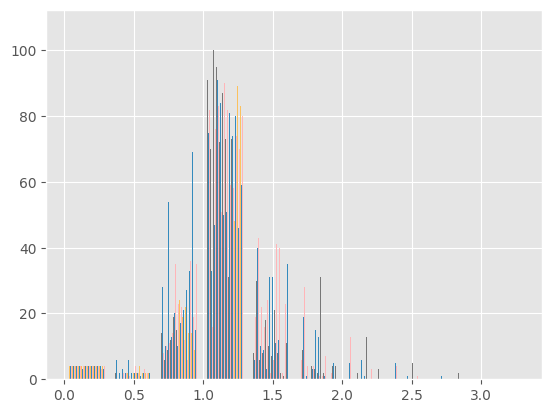

In [ ]:
df = pd.read_excel(DataPath)
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size =119
  out_columns = df.columns.str.contains('_SUVR')
  feature_columns = df.columns.str.contains('_VOLUME')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[119])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(RMSE_NN)
print(R2)

SVM Implementation

In [ ]:
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  out_columns = df.columns.str.contains('SUVR')
  feature_columns = df.columns.str.contains('_VOLUME')
  j=0
  target_cols = []
  feature_cols = []
  for col in test_ds.columns:
    if out_columns[j] == True:
      target_cols.append(col)
    if feature_columns[j] == True:
      feature_cols.append(col)
    j=j+1
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(RMSE_SVM)
print(R2)

1.1047195459914323
-75.31449236148958
[1.10184513 1.12724364 1.08246635 1.08933502 1.12270759]
[-89.80051104 -62.63850713 -83.75248339 -68.74554864 -71.6354116 ]


#Single Input ROI Volume to SUVR Scores with PHC scores as additional Inputs (ROI Volume inputs with SUVR outputs)

Here developed a single input of an ROI Volume rather than a fully connected network that allows cross talk between different ROIs. This allows a one to one relationship with an ROI Volume and its corresponding SUVR score.

New Neural Net Classifier For a Single Input system

In [ ]:
# Build a classifier in PyTorch
class NeuralNetClassifier(nn.Module):
    def __init__(self, input_size=None, nr_classes=1, hidden_layer_sizes=[16,8], save_path="models"):
        super().__init__()
        self.name = self.__class__.__name__ + '-'.join([str(n) for n in hidden_layer_sizes])
        self.save_path = save_path
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        # Define the architecture of the model
        layers = []
        nr_neurons = [input_size] + hidden_layer_sizes
        for ix in range(len(nr_neurons)-1):
            # A linear, fully-connected layer
            layers.append(nn.Linear(nr_neurons[ix], nr_neurons[ix+1]))
            # A ReLU activation function
            layers.append(nn.ReLU())
        # Final layer, in this (nr_classes==1) classification
        layers.append(nn.Linear(nr_neurons[-1], nr_classes))
        # Finally, we place them one after the other
        self.layers = nn.Sequential(*layers)
        # The softmax function ensures we have one output per class, and these add up to 1
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        '''Forward pass'''
        logits = self.layers(x)
        return logits

    def predict(self, X):
        '''Make a prediction based on a given input'''
        self.eval()
        with torch.no_grad():
            pred = self(X)
            return int(pred.argmax().detach())

    def save(self, state_name='last', verbose=False):
        '''Saves a model state in the defined path, with the model name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        torch.save(self.state_dict(), os.path.join(self.save_path, model_state_name))
        if verbose:
            print("Saved PyTorch model state {} in {}".format(model_state_name, self.save_path))

    def restore(self, state_name):
        '''Restores a model state for the given state name'''
        model_state_name = self.name+'_'+state_name+'.pth'
        self.load_state_dict(torch.load(os.path.join(self.save_path, model_state_name)))

In [ ]:
from collections import Counter

# Adjust labels to start from 0

# Print label classes and counts
print(Counter(df['PTGENDER']))

Counter({2: 438, 1: 426})


In [ ]:
print(df['age'].mean())

73.85413339417447


In [ ]:
print(df['age'].max())

94.4394250513347


In [ ]:
print(df['age'].min())

55.2772073921971


First a Pearson Correlation test to see if there is any significance in the correlation of the volume scores and the confounding variables of age and gender

In [ ]:
print(stats.pearsonr(df['CTX_LH_PRECENTRAL_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.20565926414311794, pvalue=1.0493879204944676e-09)


In [ ]:
print(stats.pearsonr(df['CTX_LH_PRECENTRAL_VOLUME'] , df['PTGENDER']))

PearsonRResult(statistic=-0.32306890355489226, pvalue=1.9375796349713938e-22)


In [ ]:
print(stats.pearsonr(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'] , df['PTGENDER']))

PearsonRResult(statistic=-0.3990053240183067, pvalue=2.354252230358549e-34)


In [ ]:
print(stats.pearsonr(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.16396929275450728, pvalue=1.2626318692775976e-06)


In [ ]:
print(stats.pearsonr(df['CTX_RH_TEMPORALPOLE_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.056319596140976216, pvalue=0.09805279358418464)


In [ ]:
print(stats.pearsonr(df['CTX_RH_TEMPORALPOLE_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.056319596140976216, pvalue=0.09805279358418464)


In [ ]:
print(stats.pearsonr(df['CTX_RH_MIDDLETEMPORAL_VOLUME'] , df['PTGENDER']))

PearsonRResult(statistic=-0.3172706167011269, pvalue=1.173062427630548e-21)


In [ ]:
print(stats.pearsonr(df['CTX_RH_MIDDLETEMPORAL_VOLUME'] , df['age']))

PearsonRResult(statistic=-0.227052860288049, pvalue=1.4513217485712156e-11)


# PHC Memory Volume+PHC score to SUVR output

['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.6941037433488029
Epoch 5 loss 0.8753581643104553
Epoch 10 loss 0.44229816581521714
Epoch 15 loss 0.20268990227154324
Epoch 20 loss 0.08603153968495982
Epoch 25 loss 0.03778130940294692
Epoch 30 loss 0.022235110102753555
Epoch 35 loss 0.018448130546935965
Epoch 40 loss 0.017800739889831416
Epoch 45 loss 0.019541250285692514
Epoch 50 loss 0.01758355470706842
Epoch 55 loss 0.0176264632459996
Epoch 60 loss 0.017568074991660458
Epoch 65 loss 0.018043631074085298
Epoch 70 loss 0.017554921730022346
Epoch 75 loss 0.017588023209412183
Epoch 80 loss 0.017620729936087237
Epoch 85 loss 0.017563583291069204
Epoch 90 loss 0.017607443269142615
Epoch 95 loss 0.017552139222555396
Finished training!
['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layer

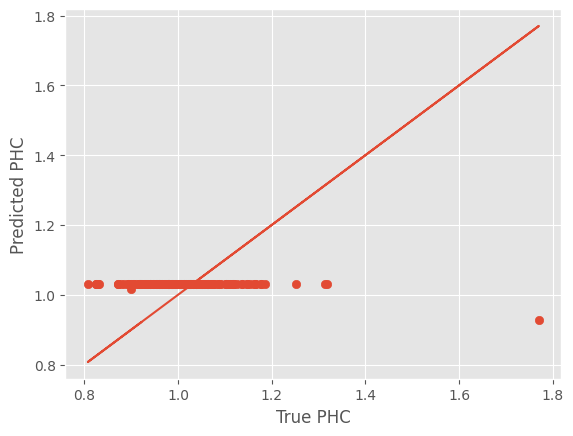

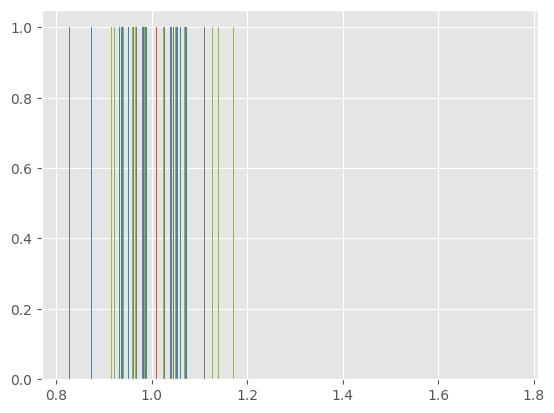

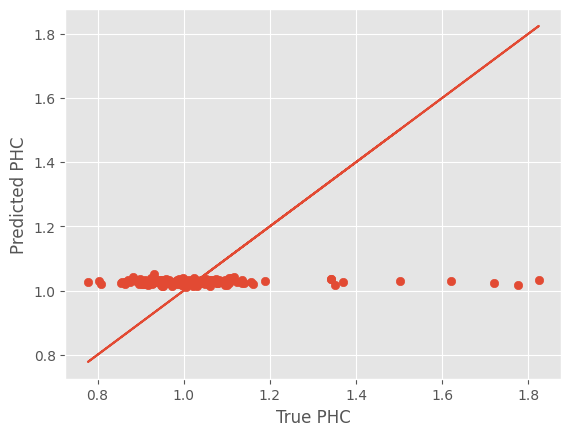

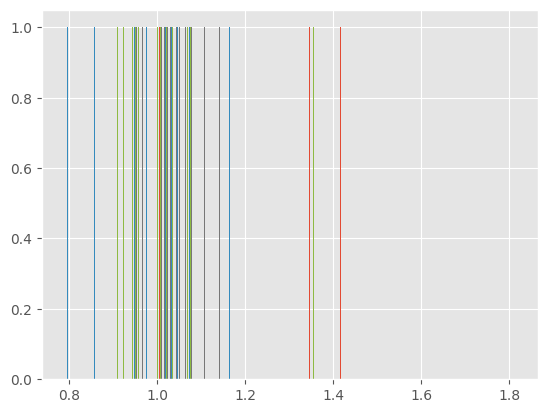

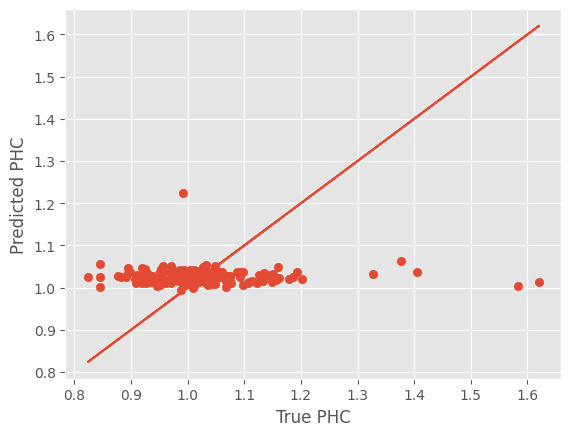

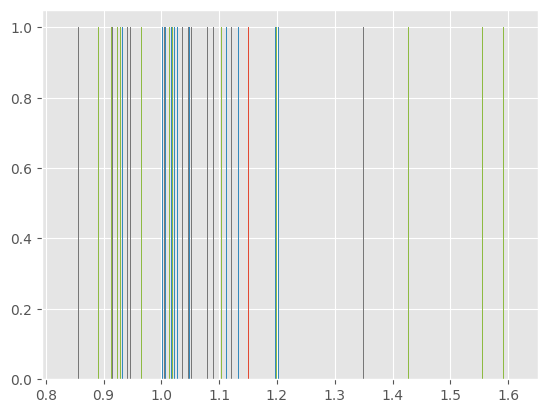

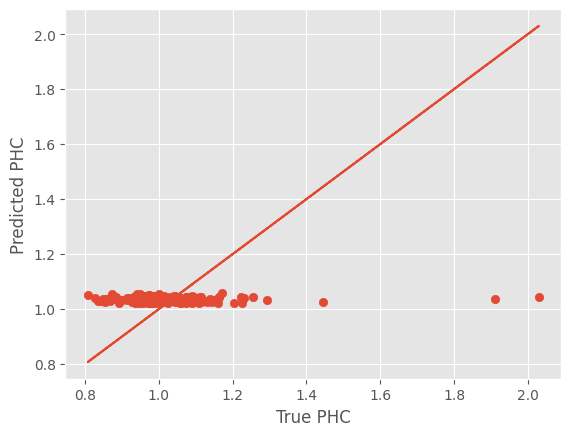

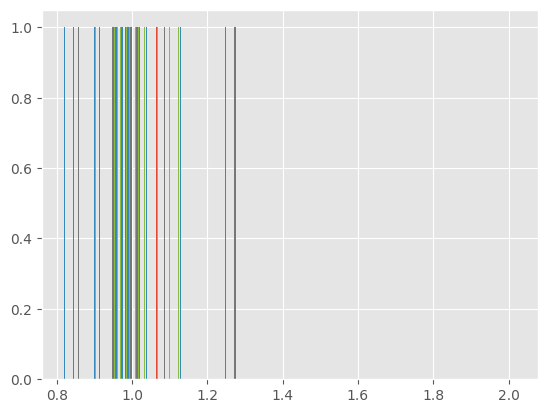

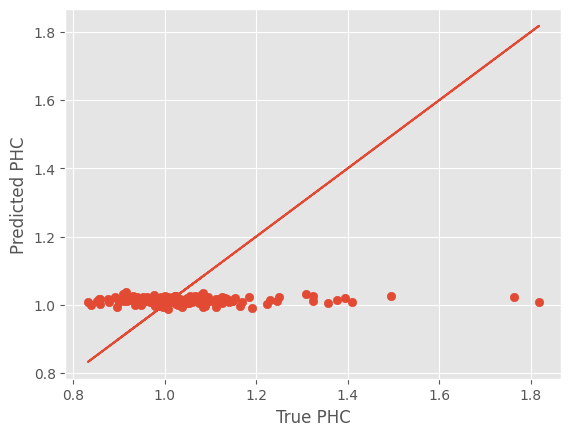

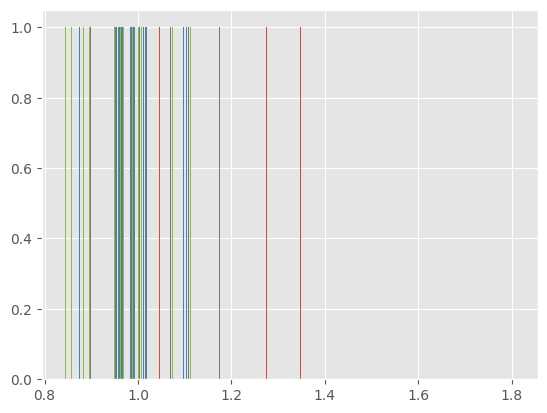

In [ ]:
#PHC_MEM
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])
df['PHC_MEM_mannualJoin'] = stats.zscore(df['PHC_MEM_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME','PHC_MEM_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i] = eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC Memory Volume to SUVR output

['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.15889534737382616
Epoch 5 loss 0.024093214804971858
Epoch 10 loss 0.01881315268110484
Epoch 15 loss 0.018081908989032464
Epoch 20 loss 0.017728232667182705
Epoch 25 loss 0.017677506987404612
Epoch 30 loss 0.017607354748179205
Epoch 35 loss 0.017782112626758006
Epoch 40 loss 0.017755343016636158
Epoch 45 loss 0.017586998944170772
Epoch 50 loss 0.017607988058132053
Epoch 55 loss 0.0181783122775544
Epoch 60 loss 0.017596260030820432
Epoch 65 loss 0.01762040267266067
Epoch 70 loss 0.017687490936701317
Epoch 75 loss 0.017610800046739834
Epoch 80 loss 0.01760735552026225
Epoch 85 loss 0.017747285799123345
Epoch 90 loss 0.017636466264126023
Epoch 95 loss 0.017757964357068497
Finished training!
['CTX_LH_PRECENTRAL_SUVR']
NeuralNetClassifier(
  (

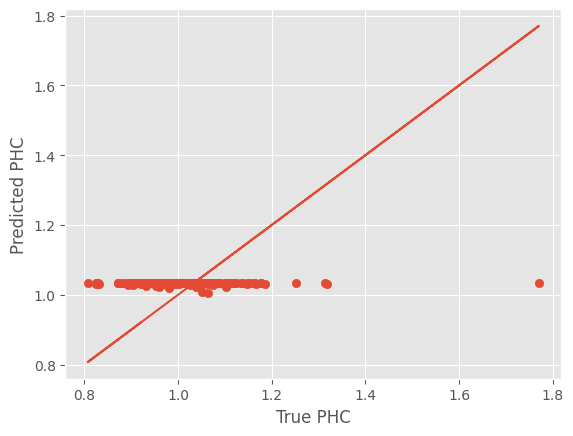

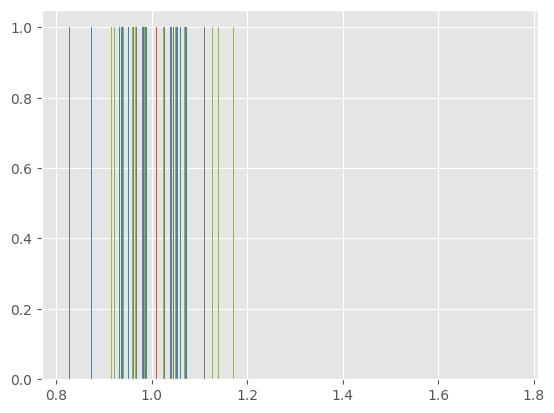

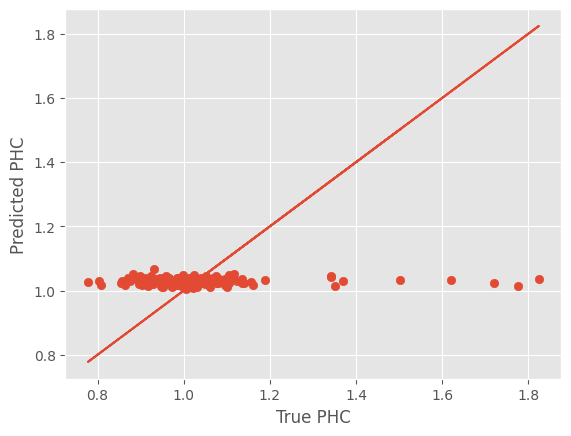

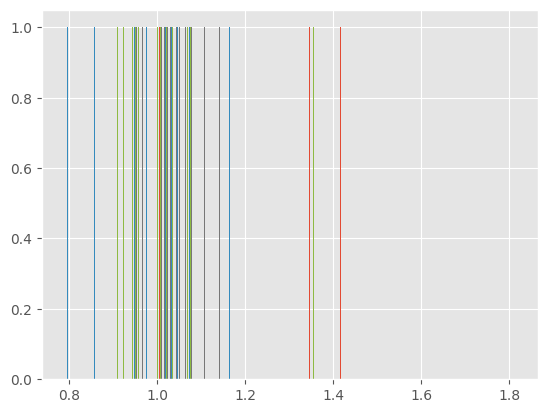

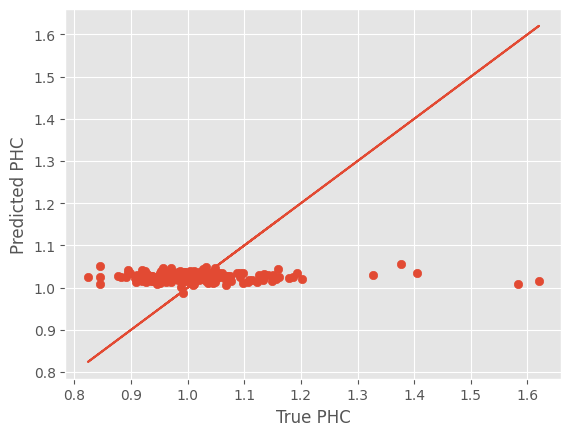

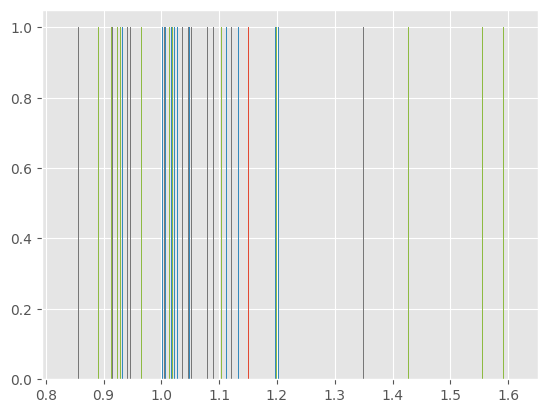

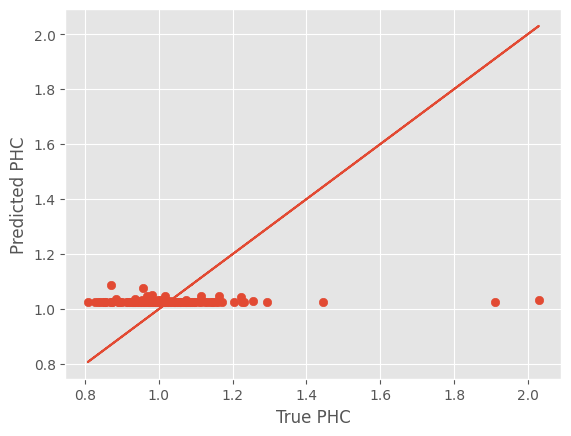

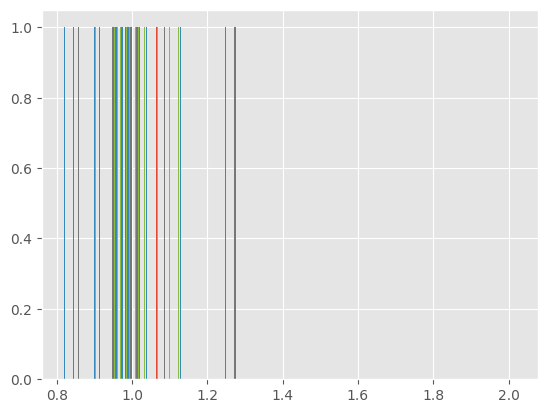

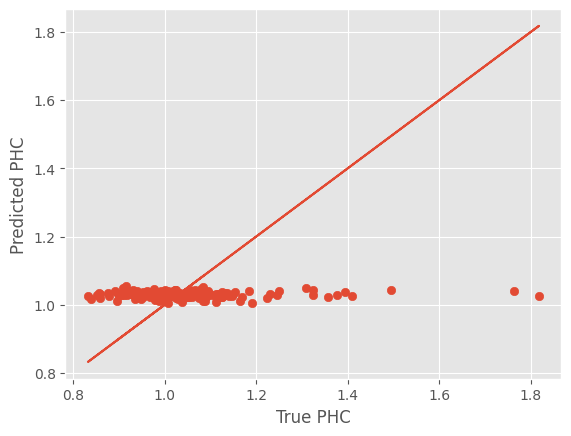

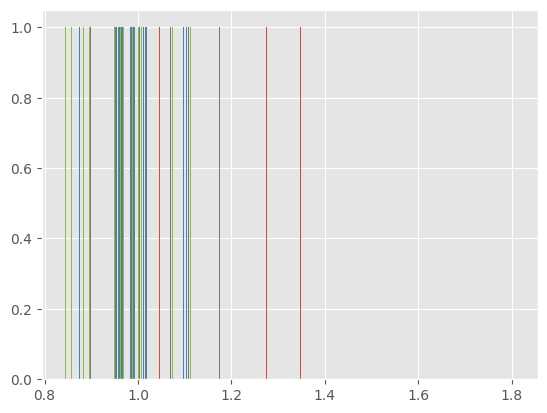

In [ ]:
#PHC_MEM
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC EXF Volume+PHC score to SUVR output

['RIGHT_CEREBELLUM_CORTEX_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 2.1965592384338377
Epoch 5 loss 0.7892171253051077
Epoch 10 loss 0.10300837151174035
Epoch 15 loss 0.0016513439194698418
Epoch 20 loss 0.0008994750495600913
Epoch 25 loss 0.0008449774846667424
Epoch 30 loss 0.0007983652623287136
Epoch 35 loss 0.0007597000379714051
Epoch 40 loss 0.0007214355709688139
Epoch 45 loss 0.0007166516404790205
Epoch 50 loss 0.0006807967149403079
Epoch 55 loss 0.0006653832976423603
Epoch 60 loss 0.0006637382057046384
Epoch 65 loss 0.0006526675366330892
Epoch 70 loss 0.0006490698947995302
Epoch 75 loss 0.0006575518842769919
Epoch 80 loss 0.0006603247207489663
Epoch 85 loss 0.0006531154329422861
Epoch 90 loss 0.0006499561228078424
Epoch 95 loss 0.0006885385207299675
Finished training!
['RIGHT_CEREBELLUM_CORTEX_S

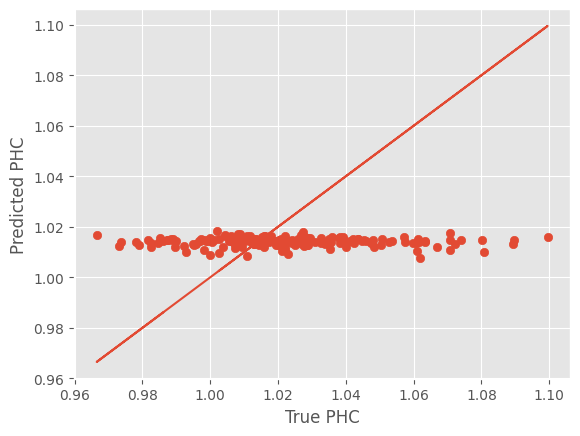

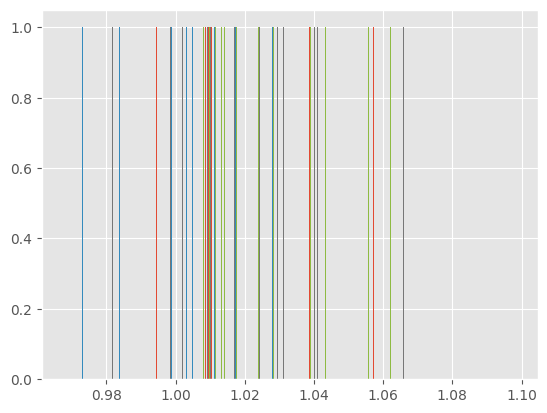

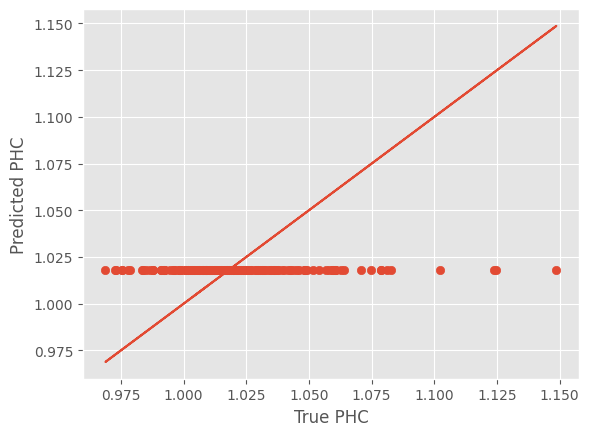

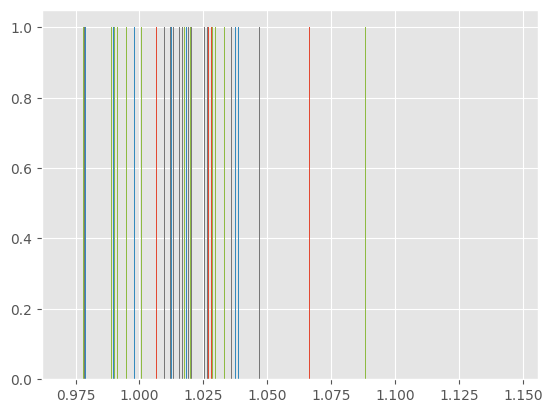

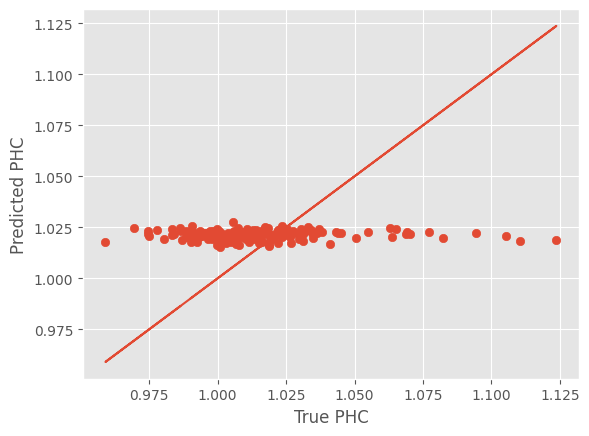

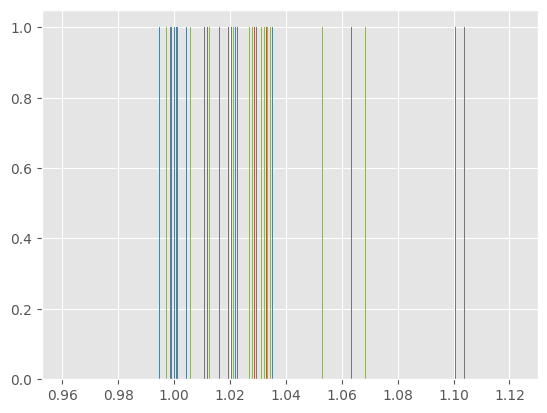

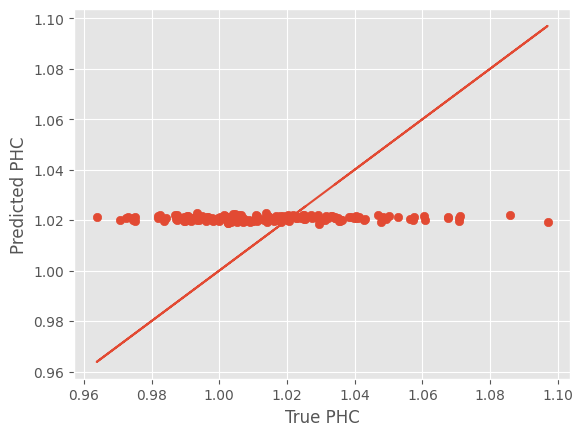

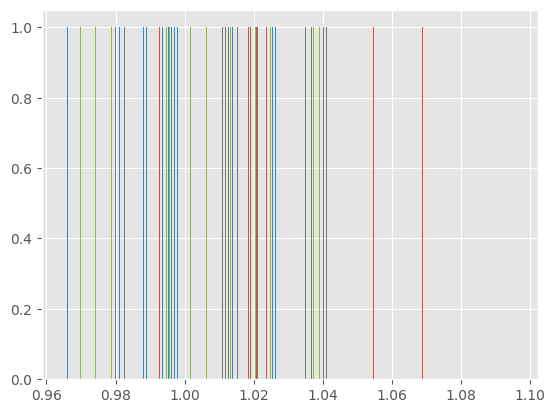

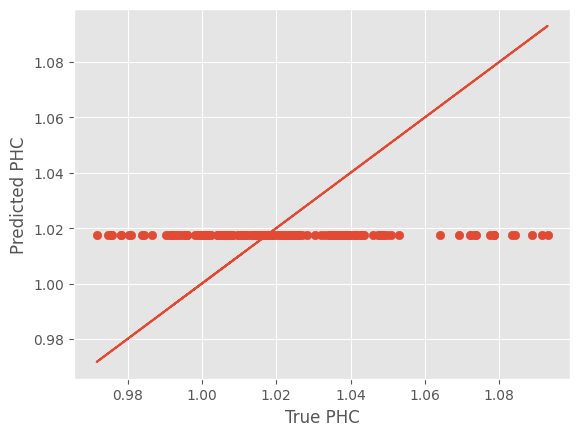

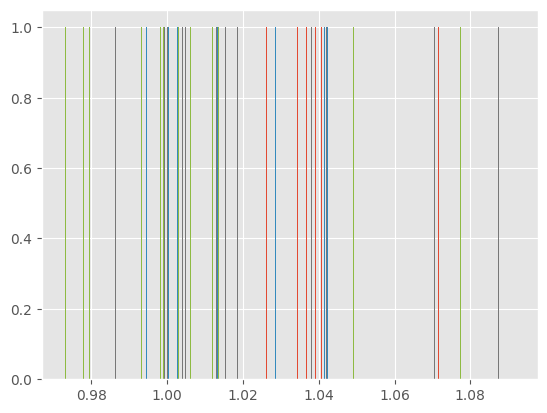

In [ ]:
#PHC_EXF
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])
df['PHC_EXF_mannualJoin'] = stats.zscore(df['PHC_EXF_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME','PHC_EXF_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC EXF Volume to SUVR output

['RIGHT_CEREBELLUM_CORTEX_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 3.9281089101518902
Epoch 5 loss 2.087524208000728
Epoch 10 loss 1.2140564152172633
Epoch 15 loss 0.6990155364785876
Epoch 20 loss 0.37800645998546056
Epoch 25 loss 0.18587701341935567
Epoch 30 loss 0.08050803371838161
Epoch 35 loss 0.030102072629545416
Epoch 40 loss 0.009599790941657764
Epoch 45 loss 0.0028141263273677654
Epoch 50 loss 0.0010582678028315839
Epoch 55 loss 0.0007265590841208385
Epoch 60 loss 0.0006777854919034456
Epoch 65 loss 0.000672100316504449
Epoch 70 loss 0.0006854188014196032
Epoch 75 loss 0.000663939502555877
Epoch 80 loss 0.0006649675968219526
Epoch 85 loss 0.0006570317718537158
Epoch 90 loss 0.0006571051816406128
Epoch 95 loss 0.0006523459153998244
Finished training!
['RIGHT_CEREBELLUM_CORTEX_SUVR']
NeuralNet

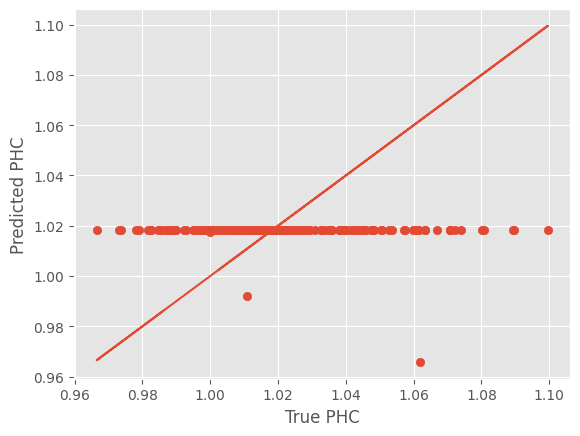

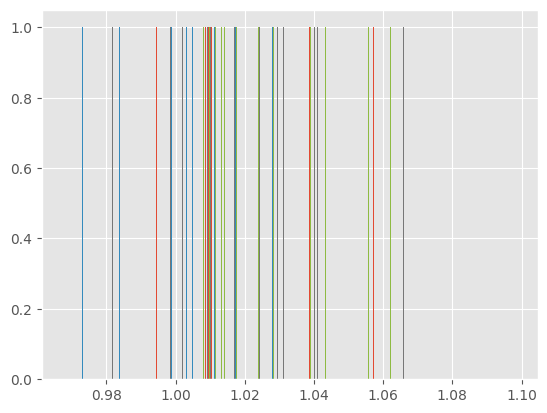

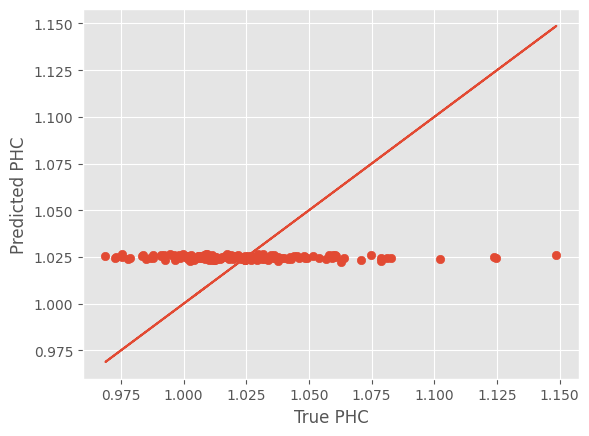

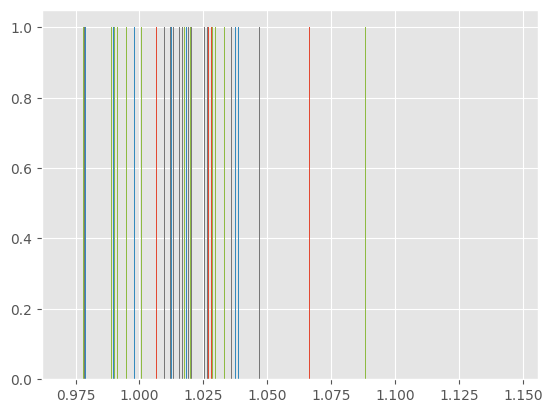

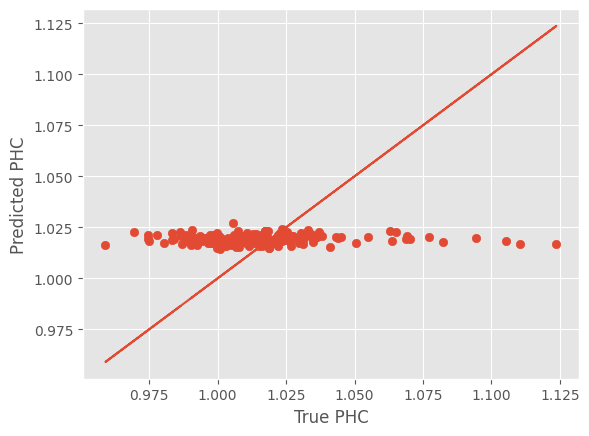

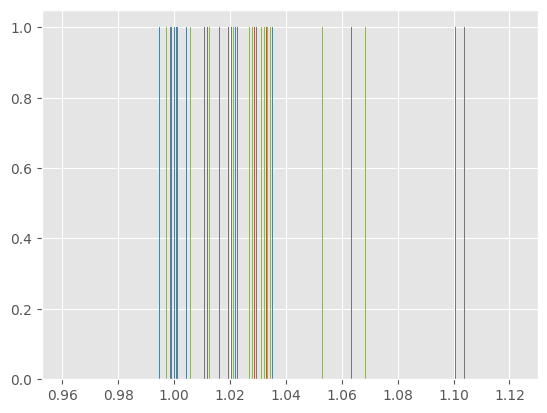

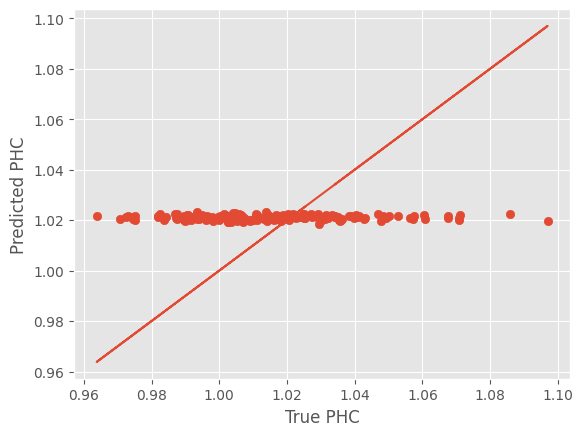

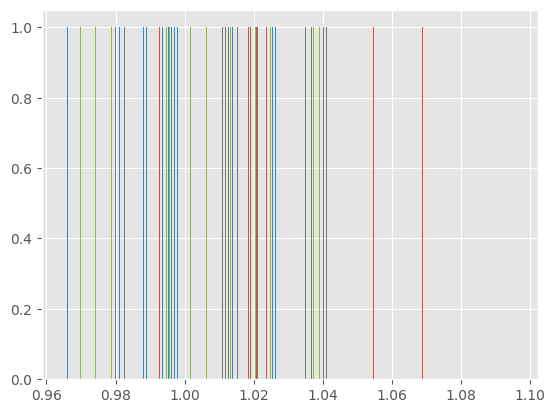

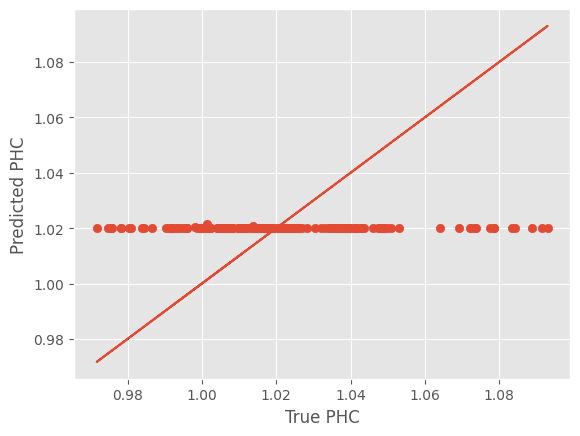

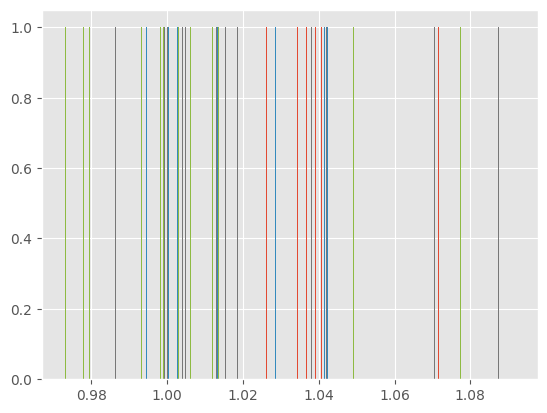

In [ ]:
#PHC_EXF
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i],R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC LAN Volume+PHC score to SUVR output

['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.3811952177967344
Epoch 5 loss 0.11578076500445604
Epoch 10 loss 0.08493816484031932
Epoch 15 loss 0.0778406917117536
Epoch 20 loss 0.07567815968899855
Epoch 25 loss 0.07531599045864174
Epoch 30 loss 0.0753589364167835
Epoch 35 loss 0.07547135381028056
Epoch 40 loss 0.07474886343947479
Epoch 45 loss 0.07460042602116508
Epoch 50 loss 0.07477031964808703
Epoch 55 loss 0.07482131236631956
Epoch 60 loss 0.07480466423689254
Epoch 65 loss 0.07455851375790579
Epoch 70 loss 0.07454230205954186
Epoch 75 loss 0.07447816624439188
Epoch 80 loss 0.07462363234455031
Epoch 85 loss 0.07448985103151894
Epoch 90 loss 0.0744900007632428
Epoch 95 loss 0.07444581446304385
Finished training!
['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): S

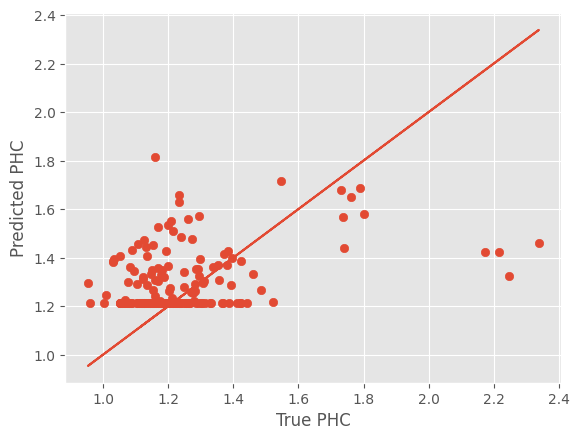

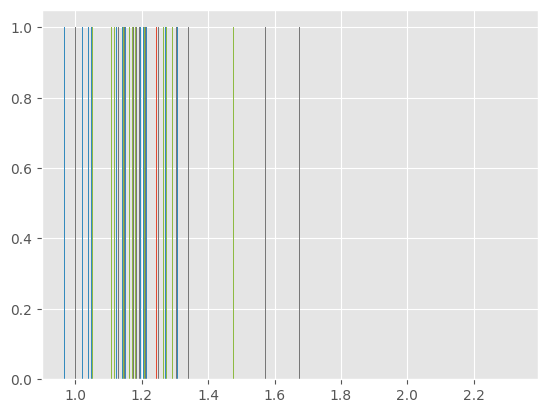

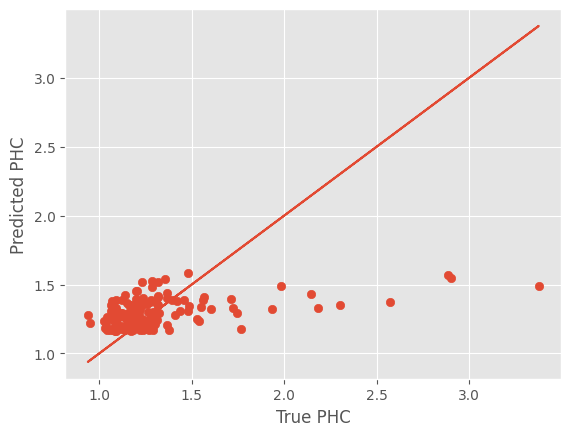

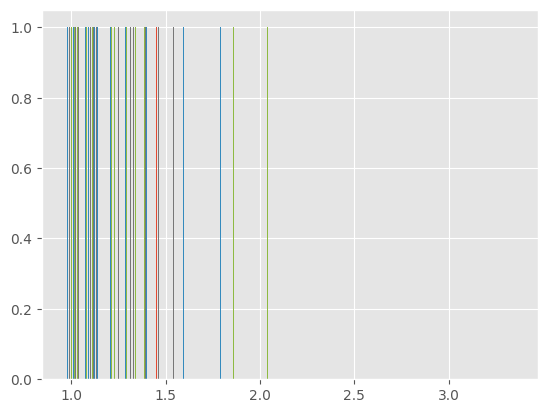

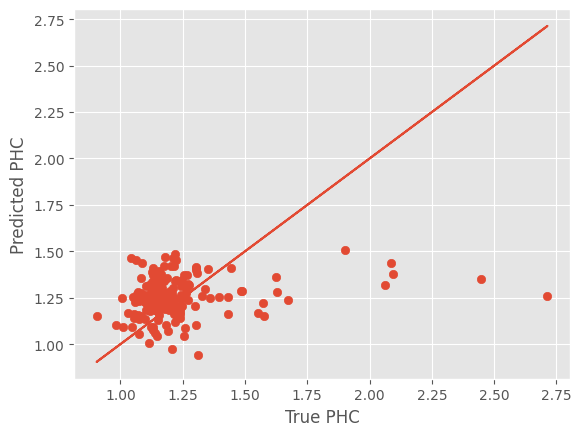

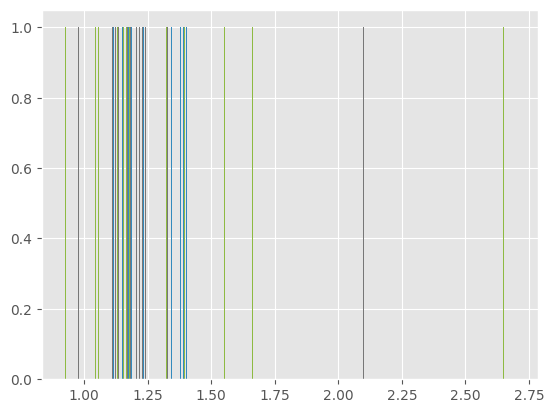

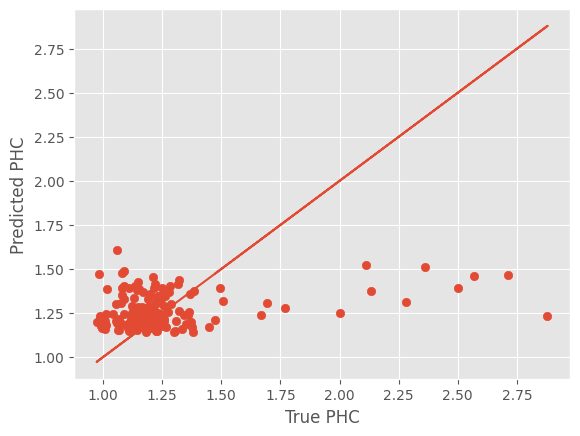

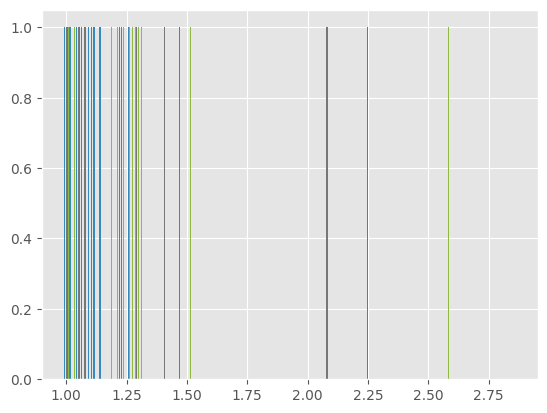

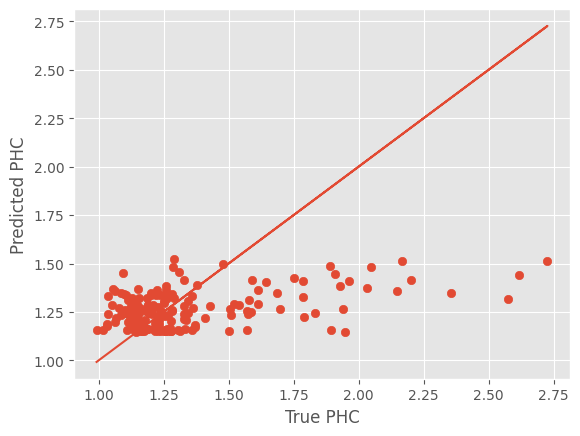

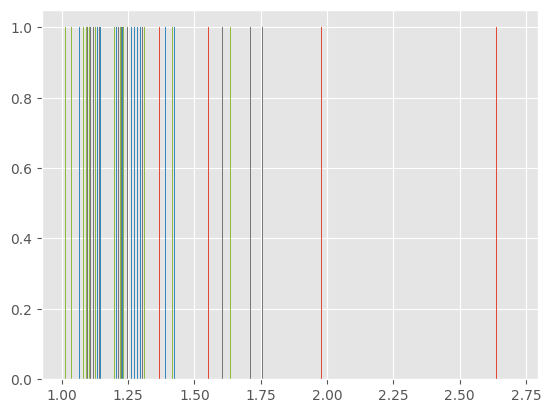

In [ ]:
#PHC_LAN
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])
df['PHC_LAN_mannualJoin'] = stats.zscore(df['PHC_LAN_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME','PHC_LAN_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC LAN Volume to SUVR output

['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 1.3248401522636413
Epoch 5 loss 0.6112798367227826
Epoch 10 loss 0.26091026469532935
Epoch 15 loss 0.08691655326235508
Epoch 20 loss 0.07857745654348816
Epoch 25 loss 0.07921967820397445
Epoch 30 loss 0.07865892363978284
Epoch 35 loss 0.07846589104405471
Epoch 40 loss 0.07844622216320464
Epoch 45 loss 0.07915377513106381
Epoch 50 loss 0.07855638562302504
Epoch 55 loss 0.07869452479561524
Epoch 60 loss 0.07888249214738607
Epoch 65 loss 0.0814567547025425
Epoch 70 loss 0.07839688138836728
Epoch 75 loss 0.07861267364184771
Epoch 80 loss 0.07902389896501388
Epoch 85 loss 0.07897028578445316
Epoch 90 loss 0.08097406337037683
Epoch 95 loss 0.078675735222974
Finished training!
['CTX_RH_MIDDLETEMPORAL_SUVR']
NeuralNetClassifier(
  (layers): Se

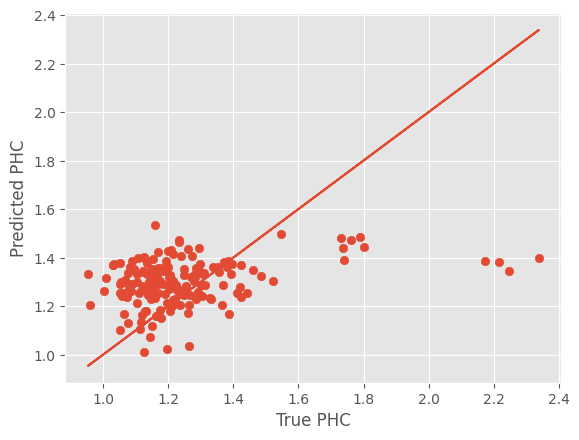

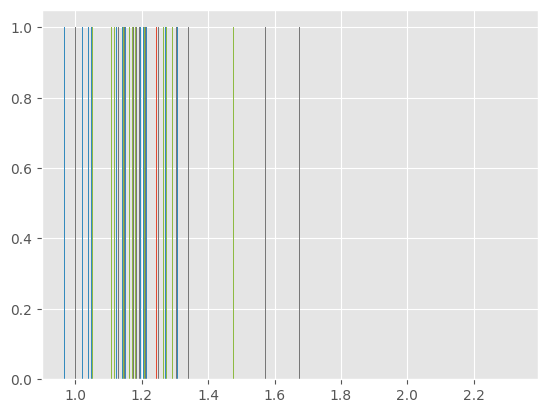

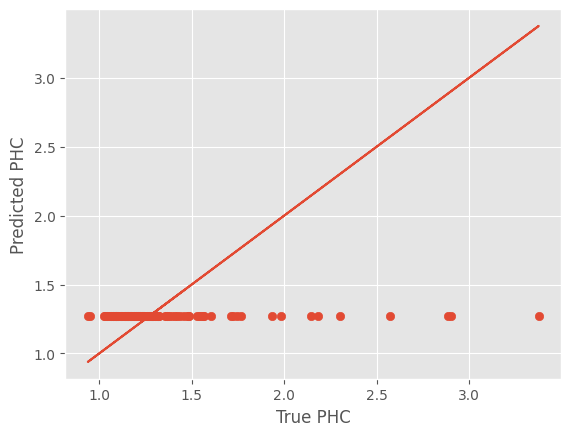

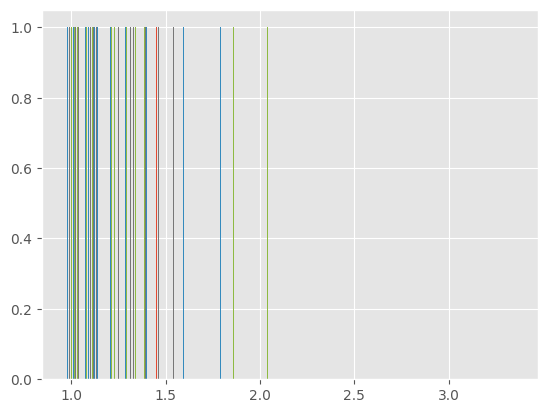

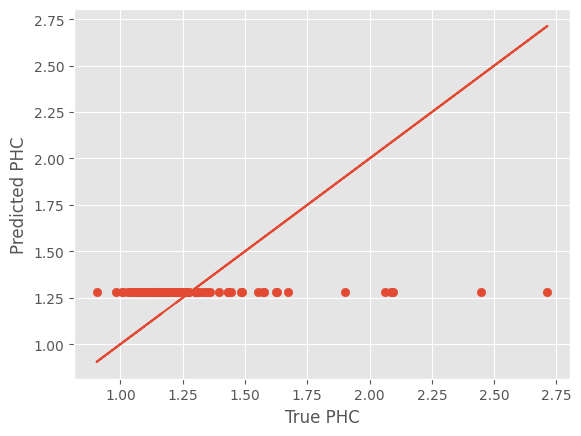

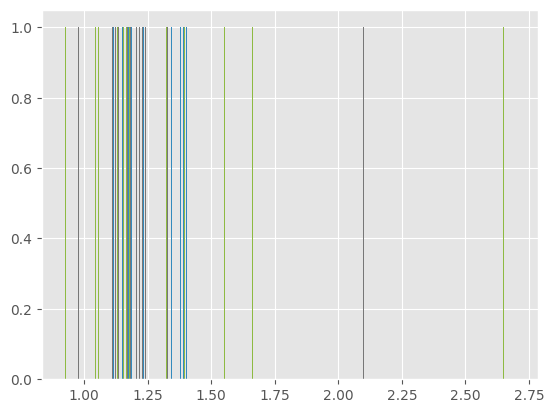

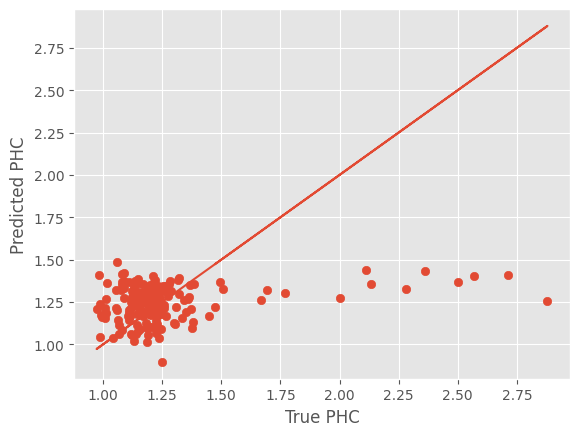

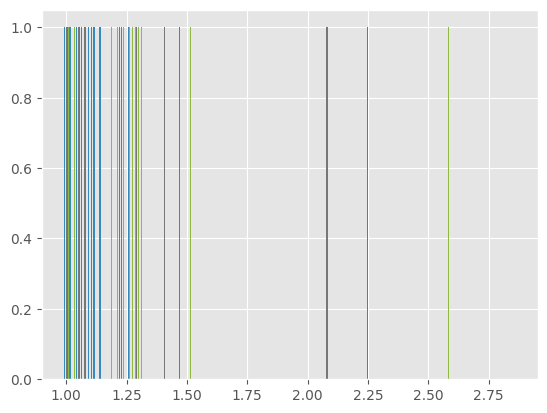

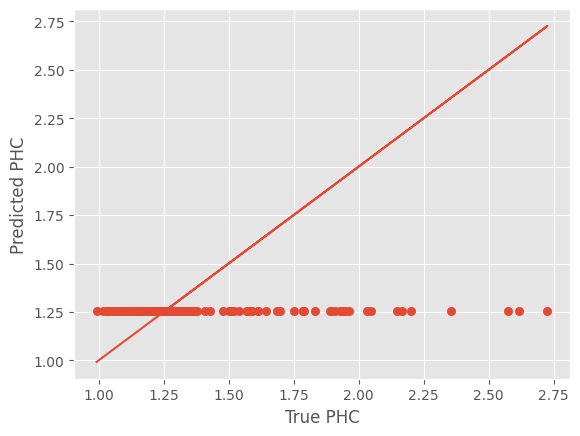

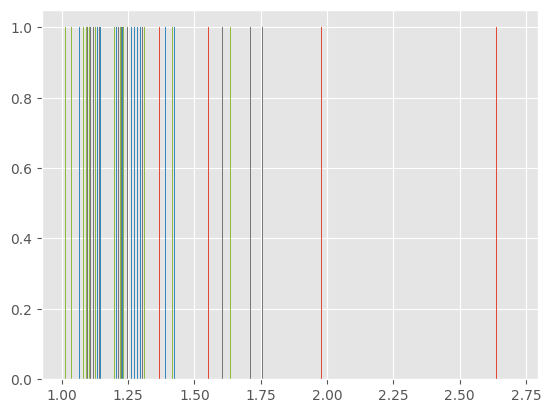

In [ ]:
#PHC_LAN
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC VSP Volume+PHC score to SUVR output

['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 2.0492587413106644
Epoch 5 loss 0.899566136939185
Epoch 10 loss 0.47515856751373836
Epoch 15 loss 0.2652928151722465
Epoch 20 loss 0.14822050130793027
Epoch 25 loss 0.08338525177511785
Epoch 30 loss 0.05363418542380844
Epoch 35 loss 0.04160201588113393
Epoch 40 loss 0.03854023904672691
Epoch 45 loss 0.03805666540616325
Epoch 50 loss 0.03779054370908333
Epoch 55 loss 0.03828805635816285
Epoch 60 loss 0.03784794476149338
Epoch 65 loss 0.03850812689135117
Epoch 70 loss 0.04072806481271982
Epoch 75 loss 0.03943014868002917
Epoch 80 loss 0.03821289532684854
Epoch 85 loss 0.037797185554102594
Epoch 90 loss 0.03801562006452254
Epoch 95 loss 0.03830604229588062
Finished training!
['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequ

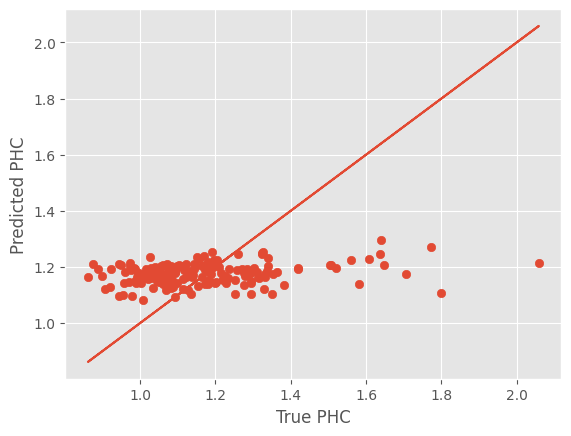

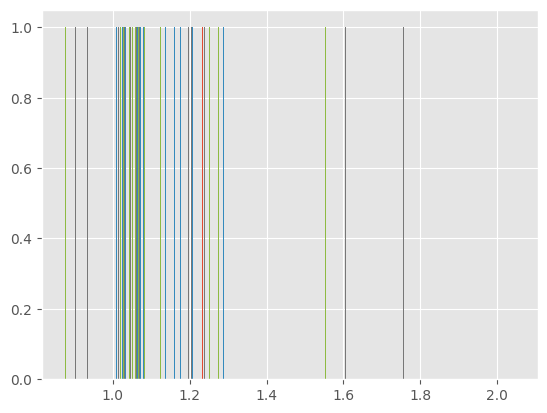

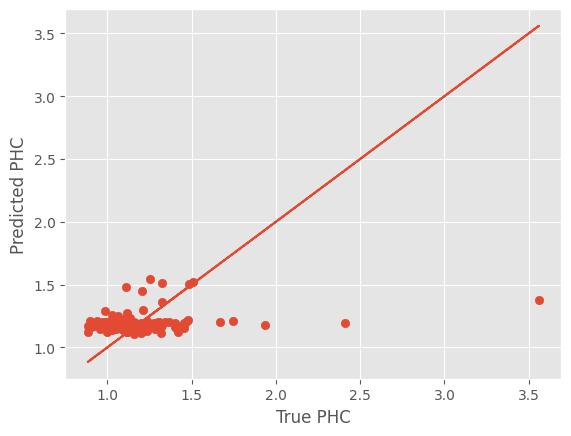

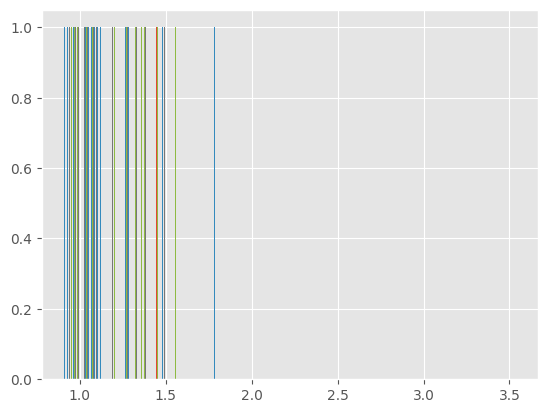

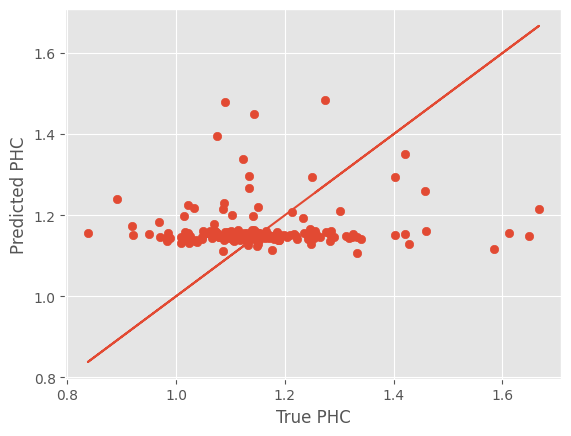

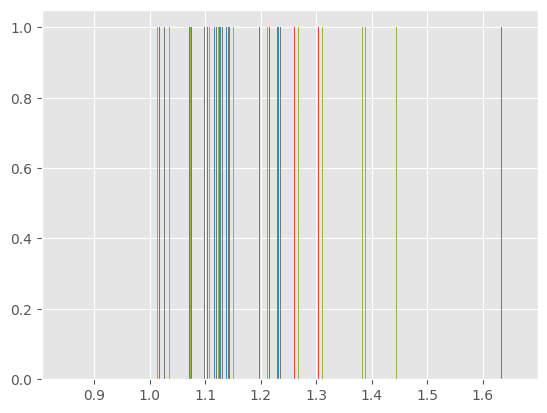

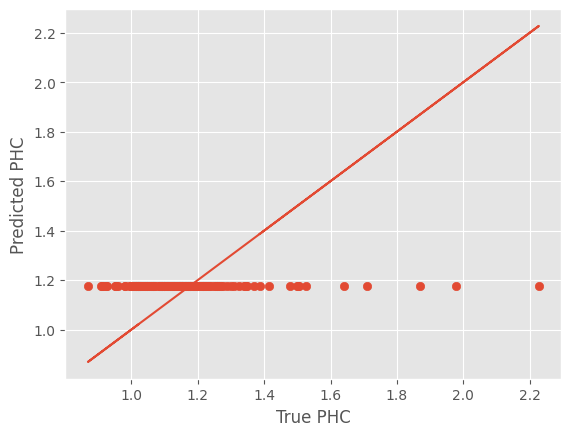

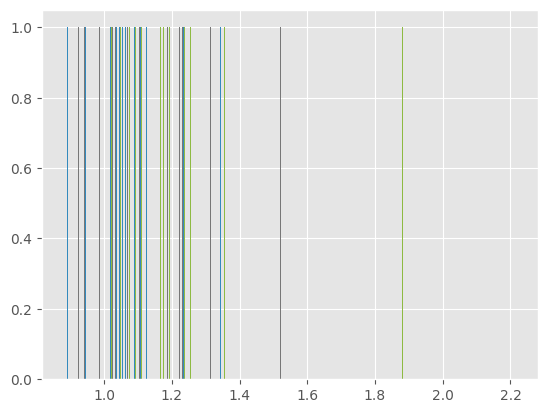

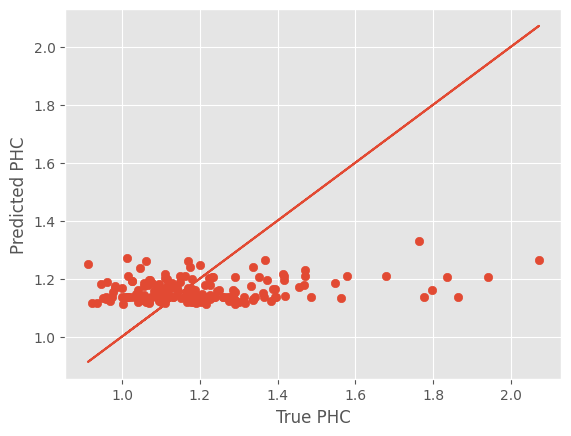

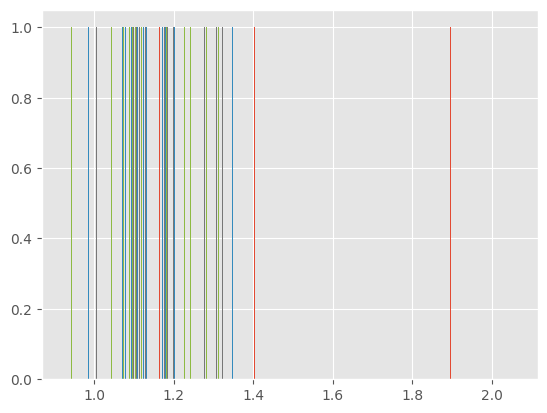

In [ ]:
#PHC_VSP
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 2
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME','PHC_VSP_mannualJoin']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[2])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# PHC VSP Volume to SUVR output

['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 2.037850034236908
Epoch 5 loss 1.1028059269700732
Epoch 10 loss 0.5622202170746667
Epoch 15 loss 0.32142954862543516
Epoch 20 loss 0.1870980059461934
Epoch 25 loss 0.11486315628779786
Epoch 30 loss 0.07114690532575228
Epoch 35 loss 0.05225375869444438
Epoch 40 loss 0.04426260442206902
Epoch 45 loss 0.039329489709676375
Epoch 50 loss 0.03803371632737773
Epoch 55 loss 0.03740892924002505
Epoch 60 loss 0.037719091686553186
Epoch 65 loss 0.0372030349880723
Epoch 70 loss 0.037797599571890064
Epoch 75 loss 0.03725583021795111
Epoch 80 loss 0.03746049142043505
Epoch 85 loss 0.037215045819591196
Epoch 90 loss 0.037299612197758895
Epoch 95 loss 0.03723739747822817
Finished training!
['CTX_RH_TEMPORALPOLE_SUVR']
NeuralNetClassifier(
  (layers): Se

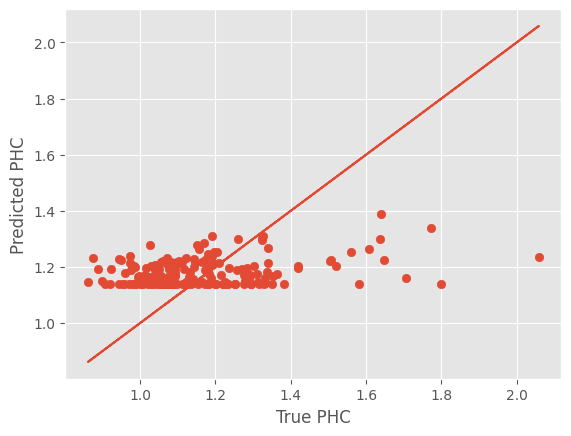

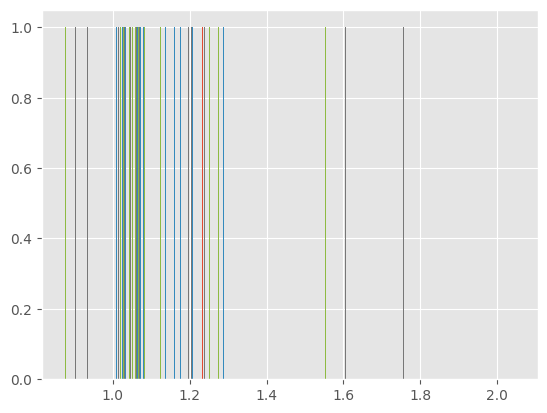

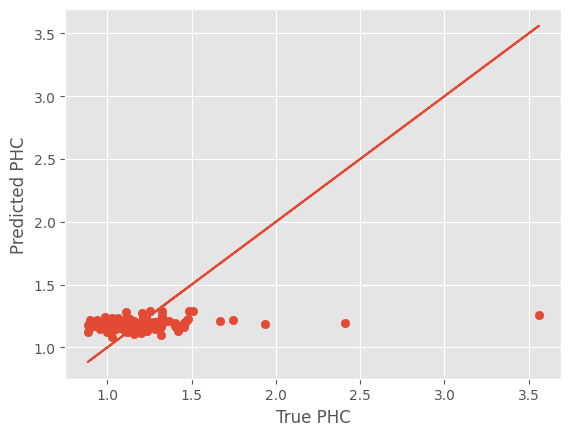

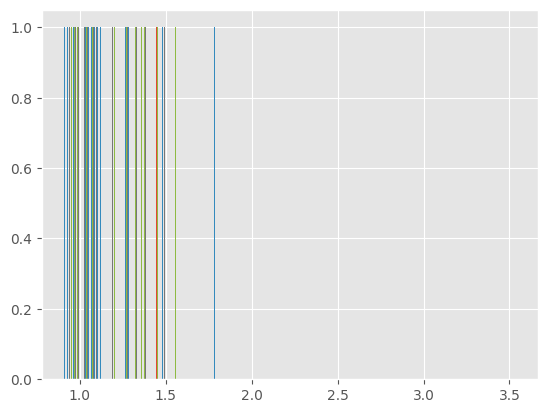

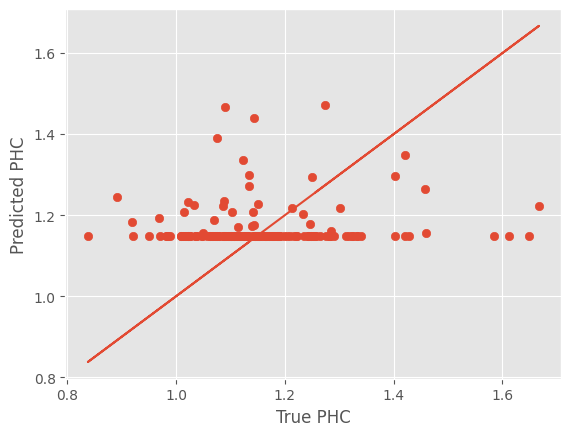

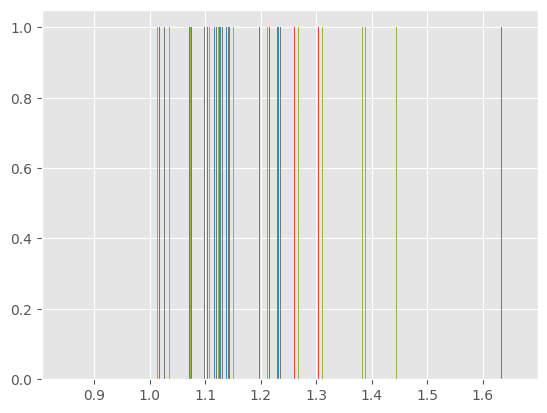

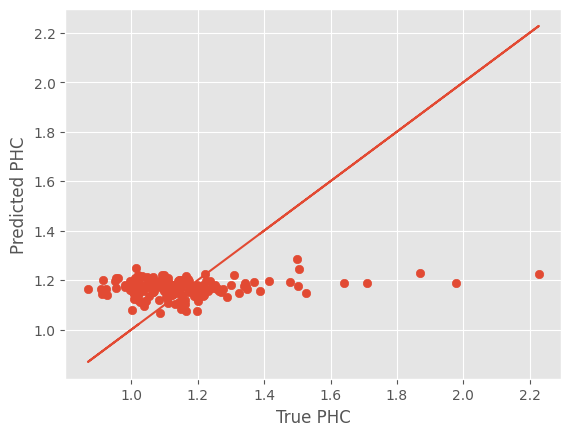

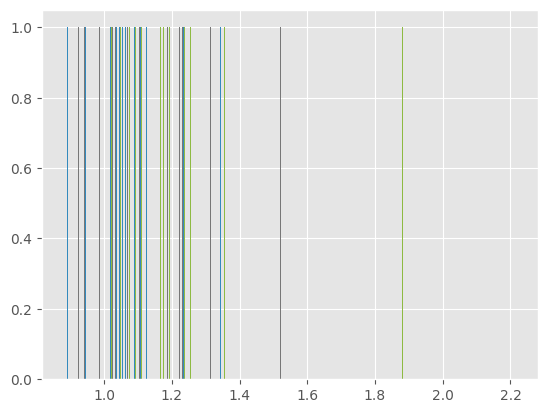

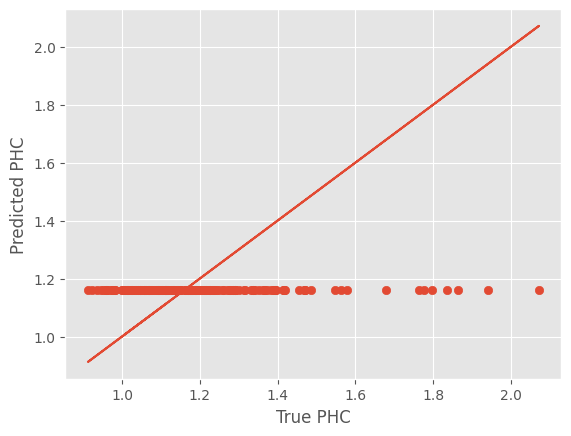

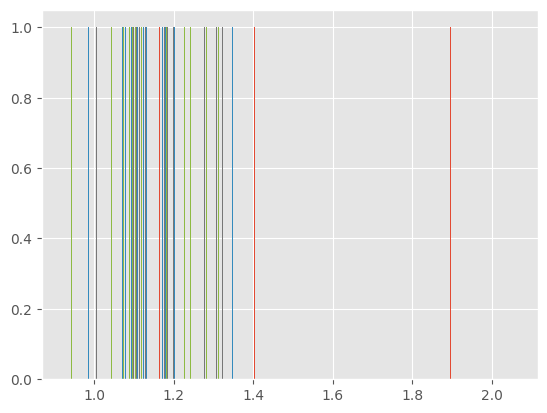

In [ ]:
#PHC_VSP
RMSE_NN = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  test_ds = df.drop(train_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  input_size = 1
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME']
  print(target_cols)
  batch_size = 10
  train_pt_ds = PandasDataset(train_ds, feature_cols=feature_cols, target_col=target_cols)
  test_pt_ds = PandasDataset(test_ds, feature_cols=feature_cols, target_col=target_cols)
  train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
  test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
  model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[1])
  print(model)
  learning_rate = 0.001
  nr_epochs = 100
  eval_every = 5
  loss_f = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
  RMSE_NN[i], R2[i]= eval_model(model,test_dl)
print(np.mean(RMSE_NN))
print(np.mean(R2))
print(R2)
print(RMSE_NN)

# SVMs

## PHC Memory Volume+PHC score to SUVR output

0.12892221739780566
-0.04699901491759999
[-0.18863301  0.00374062 -0.02758111 -0.00499779 -0.01752379]
[0.11279102 0.14569256 0.10752152 0.13880567 0.13980031]


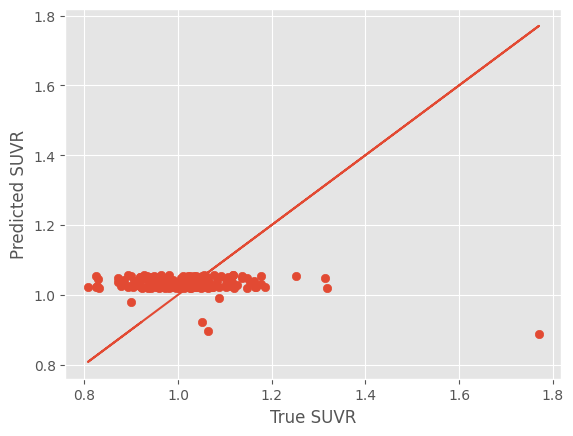

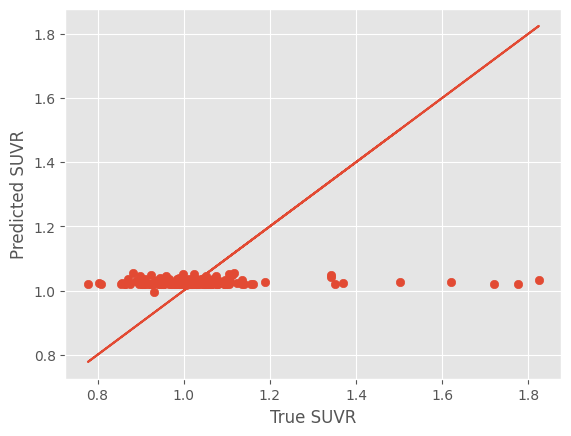

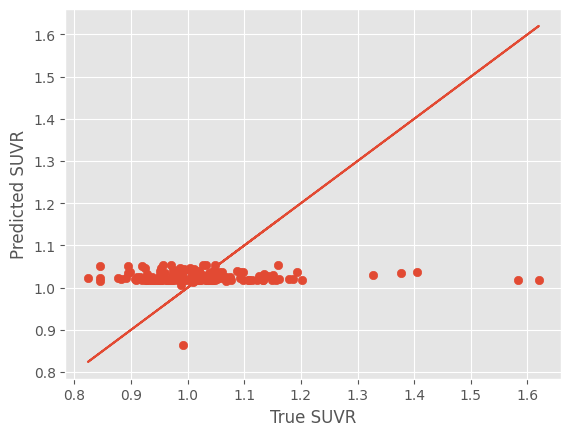

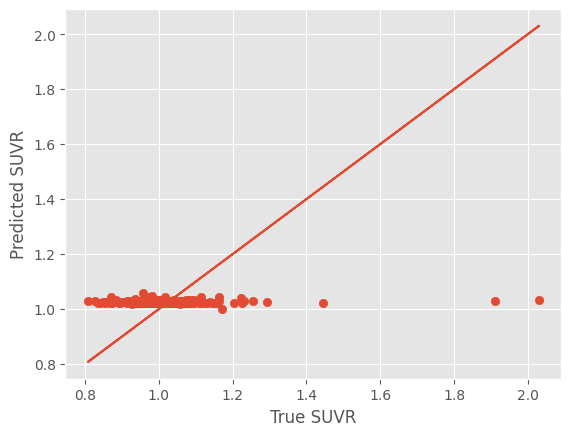

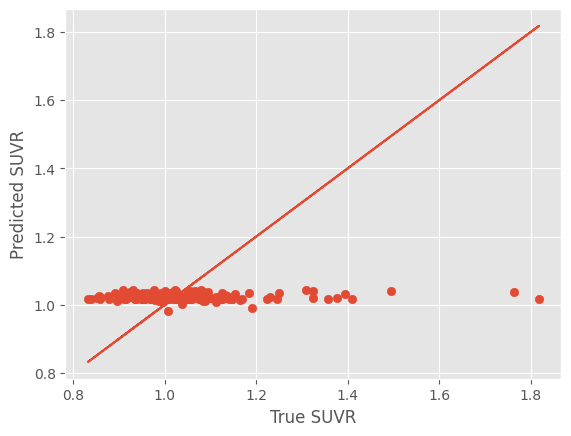

In [ ]:
#PHC MEM
RMSE_SVM = np.zeros(5)
R2= np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_LH_PRECENTRAL_VOLUME'] = stats.zscore(df['CTX_LH_PRECENTRAL_VOLUME'])
df['PHC_MEM_mannualJoin'] = stats.zscore(df['PHC_MEM_mannualJoin'])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_LH_PRECENTRAL_SUVR']
  feature_cols = ['CTX_LH_PRECENTRAL_VOLUME','PHC_MEM_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

## PHC EXF Volume+PHC score to SUVR output

0.04500032969095413
-2.1161552831922914
[-1.91012726 -1.32617439 -2.53052414 -2.1823521  -2.63159852]
[0.04357685 0.03794029 0.0481291  0.04625112 0.04910429]


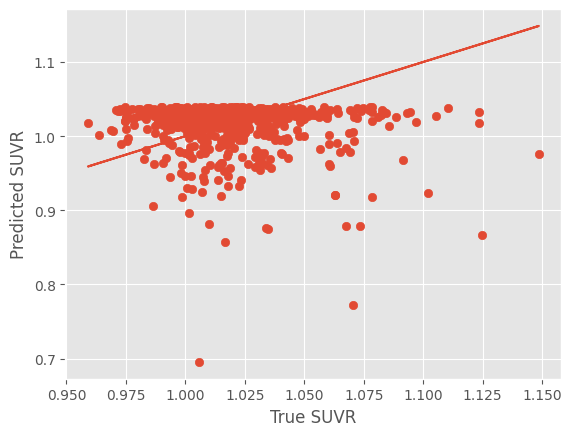

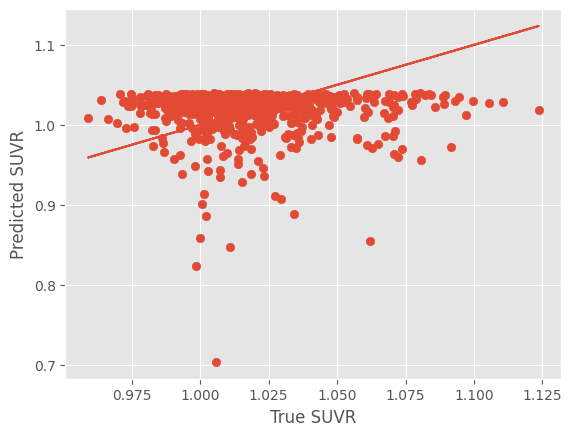

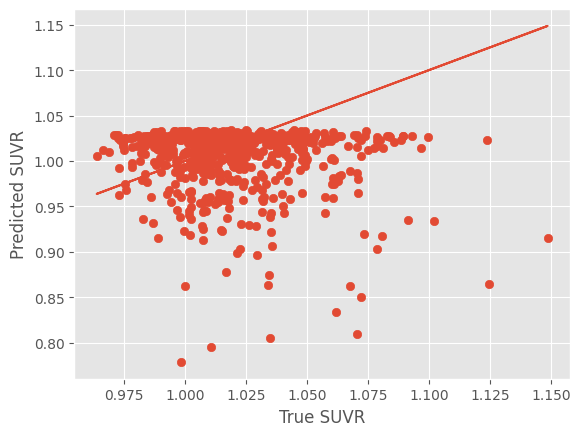

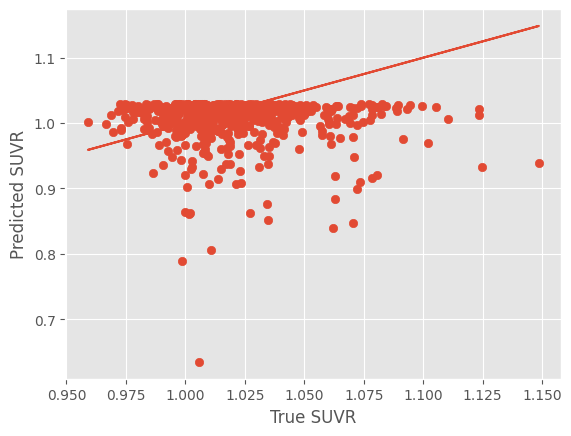

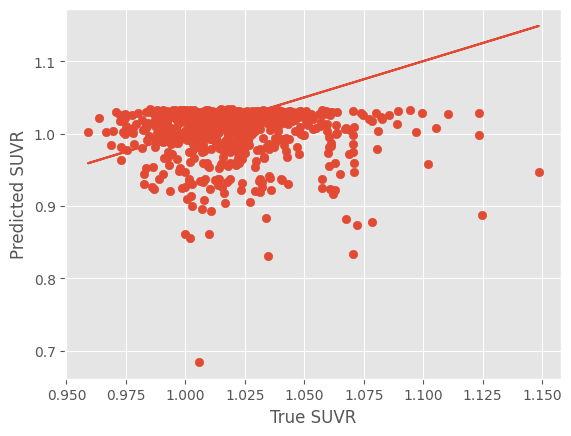

In [ ]:
#PHC EXF
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['RIGHT_CEREBELLUM_CORTEX_VOLUME'] = stats.zscore(df['RIGHT_CEREBELLUM_CORTEX_VOLUME'])
for i in range(5):
  if i==0:
    train_ds = df.iloc[(0):(+172)]
  train_ds = df.iloc[((i*172)):((i*172)+172)]
  test_ds = df.drop(train_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['RIGHT_CEREBELLUM_CORTEX_SUVR']
  feature_cols = ['RIGHT_CEREBELLUM_CORTEX_VOLUME','PHC_EXF_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

## PHC LAN Volume+PHC score to SUVR output

0.2511183284998076
0.16355526939466994
[0.03604144 0.33169477 0.06185631 0.25235602 0.1358278 ]
[0.21081649 0.27064818 0.2203942  0.2587176  0.29501516]


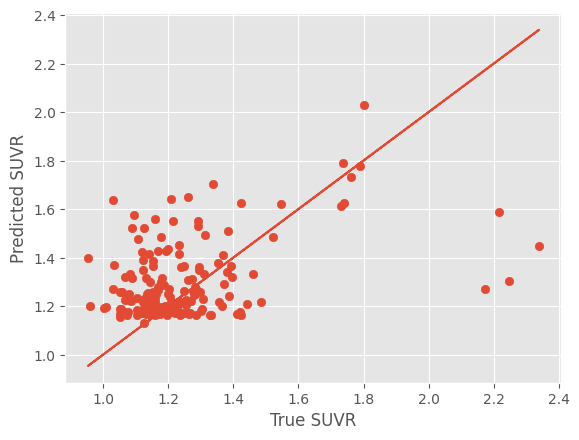

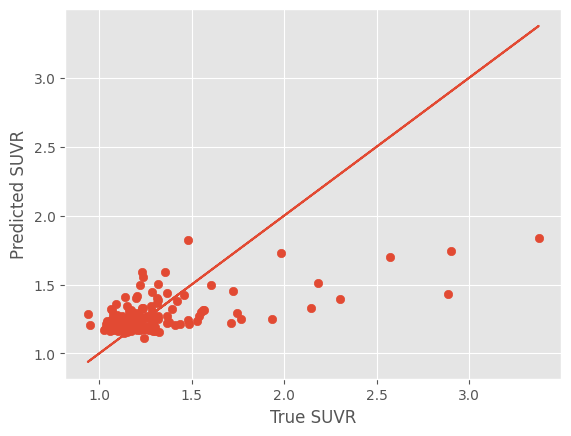

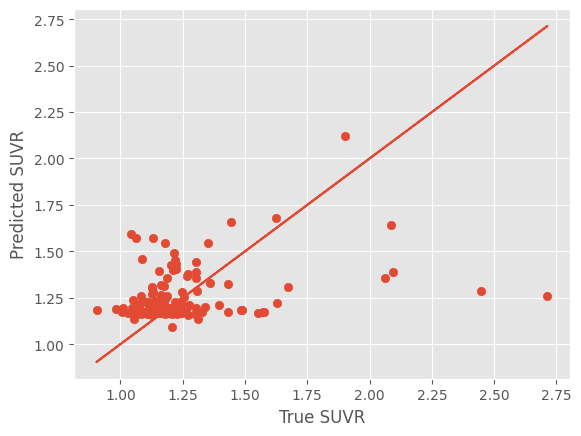

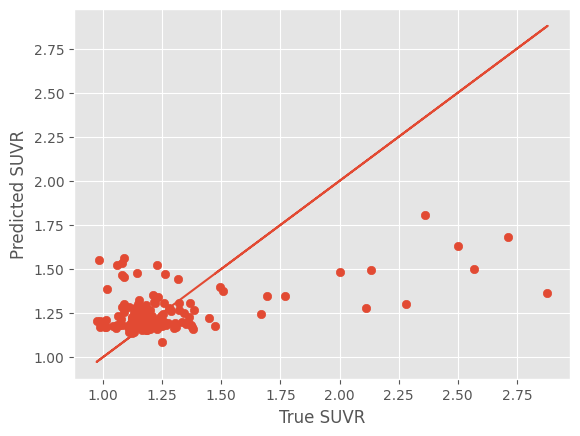

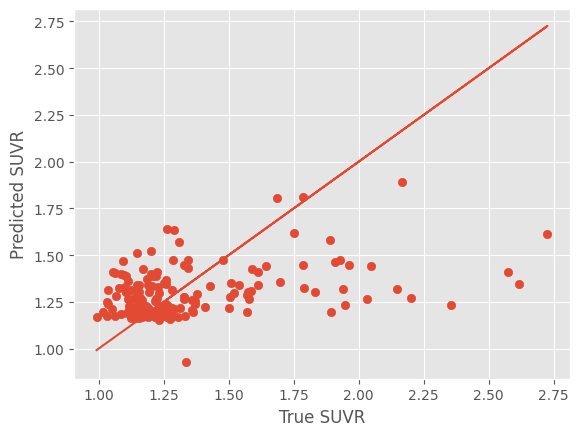

In [ ]:
#PHC LAN
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_MIDDLETEMPORAL_VOLUME'] = stats.zscore(df['CTX_RH_MIDDLETEMPORAL_VOLUME'])
for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_RH_MIDDLETEMPORAL_SUVR']
  feature_cols = ['CTX_RH_MIDDLETEMPORAL_VOLUME','PHC_LAN_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

## PHC VSP Volume+PHC score to SUVR output

0.18889587980115205
0.012574781085873132
[ 0.09927084  0.06916073 -0.14263933  0.04665194 -0.00957028]
[0.17943932 0.24938776 0.14118763 0.17451567 0.19994902]


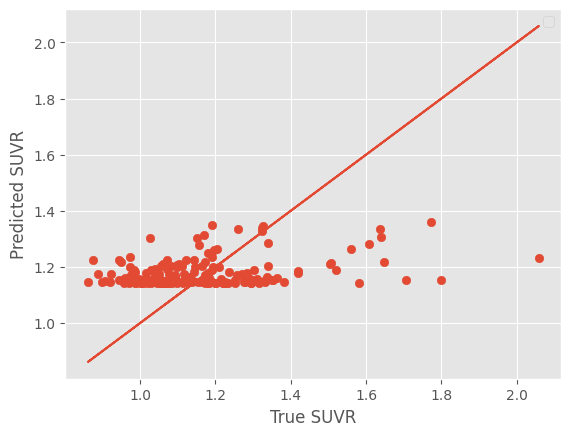

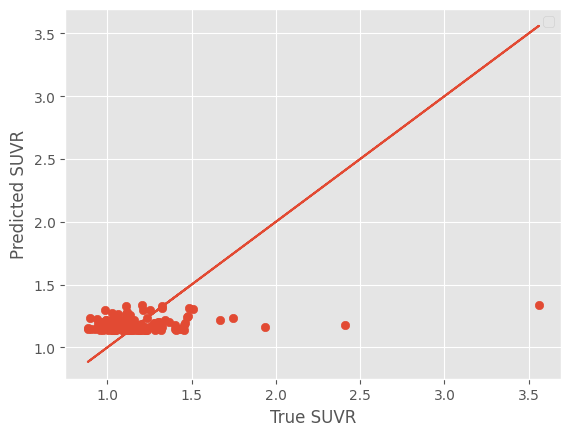

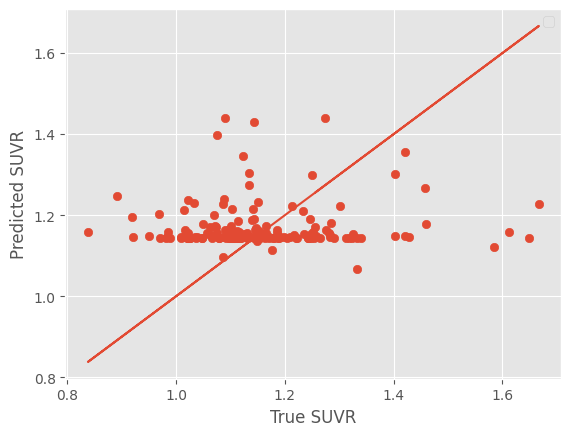

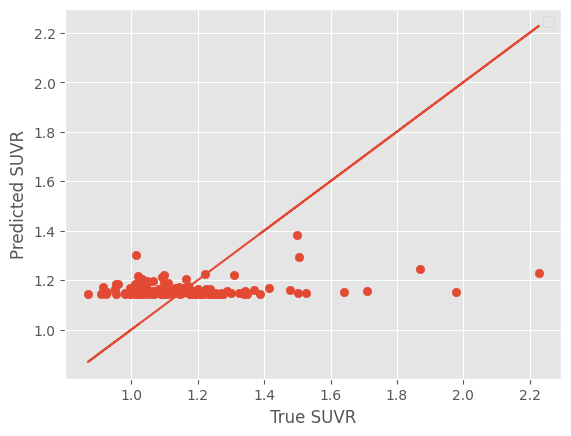

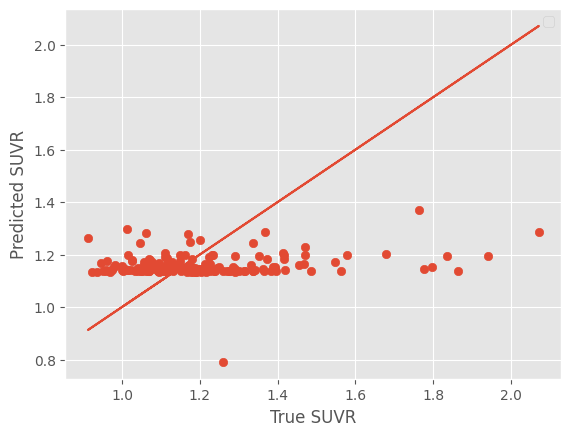

In [ ]:
#PHC VSP
RMSE_SVM = np.zeros(5)
R2 = np.zeros(5)
df = pd.read_excel(DataPath)
df ['CTX_RH_TEMPORALPOLE_VOLUME'] = stats.zscore(df['CTX_RH_TEMPORALPOLE_VOLUME'])
df['PHC_VSP_mannualJoin'] = stats.zscore(df['PHC_VSP_mannualJoin'])

for i in range(5):
  if i==0:
    test_ds = df.iloc[(0):(172)]
  else:
    test_ds = df.iloc[((i*172)):((i*172)+172)]
  train_ds = df.drop(test_ds.index)
  train_ds = train_ds.fillna(0)
  test_ds = test_ds.fillna(0)
  target_cols = ['CTX_RH_TEMPORALPOLE_SUVR']
  feature_cols = ['CTX_RH_TEMPORALPOLE_VOLUME','PHC_VSP_mannualJoin']
  j=0
  features_train = train_ds[feature_cols]
  out_train = train_ds[target_cols]
  features_test = test_ds[feature_cols]
  out_test = test_ds[target_cols]
  msvr = MSVR(kernel = 'rbf', gamma = 0.1, epsilon=0.001)
  features_train = np.array(features_train)
  out_train = np.array(out_train)
  msvr.fit(features_train, out_train)
  testPred = msvr.predict(features_test)
  out_test = np.array(out_test)
  RMSE_SVM[i]= rmse(out_test,testPred)
  R2[i] = r2_score(out_test,testPred)
  plt.figure()
  plt.scatter(out_test,testPred)
  plt.plot(out_test,out_test)
  plt.xlabel('True SUVR')
  plt.ylabel('Predicted SUVR')
  plt.legend()
print(np.mean(RMSE_SVM))
print(np.mean(R2))
print(R2)
print(RMSE_SVM)

# Ranking ROIs

In [ ]:
df_nn = df.drop(columns=['INFERIORCEREBELLUM_SUVR'])
df_nn = df_nn.fillna(0)

target_cols = [col for col in df_nn.columns if 'PHC' in col]
feature_cols = [col for col in df_nn.columns if '_SUVR' in col]
print(feature_cols)


['ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARACENTRAL_SUVR', 'CTX_LH_PARAHIPPOCAMPAL_SUVR', 'CTX_LH_PARSOPERCULARIS_SUVR', 'CTX_LH_PARSORBITALIS_SUVR', 'CTX_LH_PARSTRIANGULARIS_SUVR', 'CTX_LH_PERICALCARINE_SUVR', 'CTX_LH_POSTCENTRAL_SUVR', 'CTX_LH_POSTERIORCI

In [ ]:
def eval_model_historic(model, dl):
    model.eval() # This is important for certain stochastic elements, such as MC Dropout
    targets = []
    predictions = []
    for X, y in dl:
        pred = model(X)
        targets += list(y.detach().cpu().numpy())
        predictions += list(pred.detach().cpu().numpy())
    print(predictions)
    print(list(np.mean(np.array(targets), axis=1)))
    MAE = metrics.mean_squared_error(list(np.mean(np.array(targets), axis=1)), predictions)
    return (MAE)

    print(f"Accuracy: {accuracy}, Balanced Accuracy: {balanced_accuracy}")

In [ ]:
def run_NN(d, tc, fc, k = 5, rs = 20, lr = 0.001, nre = 100):
  ksplit = k
  RMSE_NN = np.zeros(ksplit)
  kf = KFold(n_splits=ksplit, shuffle=True, random_state=rs)   # setting random_state for repeatable results

  train_folds = []
  test_folds = []

  for i, (train, test) in enumerate(kf.split(d)):
      train_folds.append(d.iloc[train])
      test_folds.append(d.iloc[test])

  # Run Model
  for i in range(ksplit):
    train_ds = train_folds[i]
    test_ds = test_folds[i]
    input_size = 118
    batch_size = 10
    train_pt_ds = PandasDataset(train_ds, feature_cols=fc, target_col=tc)
    test_pt_ds = PandasDataset(test_ds, feature_cols=fc, target_col=tc)
    train_dl = DataLoader(train_pt_ds, batch_size=batch_size, shuffle=True) # Shuffle the train dataset!
    test_dl = DataLoader(test_pt_ds, batch_size=batch_size, shuffle=False)
    model = NeuralNetClassifier(input_size=input_size,hidden_layer_sizes=[4])
    print(model)
    learning_rate = lr
    nr_epochs = nre
    eval_every = 5
    loss_f = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_model(model, train_dl, optimizer, loss_f, nr_epochs, eval_every)
    RMSE_NN[i]= eval_model_historic(model,test_dl)
    print("RMSE for Epoch " + str(i) + " : " + str(eval_model_historic(model,test_dl)))
  return model, np.mean(RMSE_NN)

In [ ]:
standardModel, rmseVal = run_NN(df_nn, target_cols, feature_cols, k = 4)

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
Epoch 0 loss 0.7359014621147743
Epoch 5 loss 0.4987672521517827
Epoch 10 loss 0.4931755189712231
Epoch 15 loss 0.49111842008737416
Epoch 20 loss 0.49003974841191217
Epoch 25 loss 0.48901099287546596
Epoch 30 loss 0.48946849153592037
Epoch 35 loss 0.4888615649480086
Epoch 40 loss 0.48873242323215194
Epoch 45 loss 0.48842113476533155
Epoch 50 loss 0.48827864344303423
Epoch 55 loss 0.4890640300053817
Epoch 60 loss 0.4890994988954984
Epoch 65 loss 0.4888765087494483
Epoch 70 loss 0.4891994650547321
Epoch 75 loss 0.4889883110156426
Epoch 80 loss 0.4885613184708815
Epoch 85 loss 0.48914837607970607
Epoch 90 loss 0.4889765221339006
Epoch 95 loss 0.4889923375386458
Finished training!
[array([0.16653368], dtype=float32), array([0.16653368], dtype=float32), array([0.16653368], dtype=flo

In [ ]:
print(standardModel)
for param in standardModel.parameters():
  params = (param.data.numpy())
  break
max = np.zeros(4)
importance = np.zeros((4,len(feature_cols)))
print(feature_cols)
print(len(feature_cols))
print(params.shape)
ROIS = []
for i in range(4):
  max[i] = np.max(params[i,:])
  k= np.argmax(params[i,:])
  sorted_pos = np.argsort(params[i,:])
  print(feature_cols[112])
  for j in range(len(feature_cols)):
    importance[i, j] = list(sorted_pos).index(j)
  ROIS.append(feature_cols[k])

pos_mean = np.zeros(len(feature_cols))
pos_std = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  pos_mean[i] = np.mean(importance[:,i])
  pos_std[i] = np.std(importance[:,i])
for j in np.argsort(pos_mean):
  print(feature_cols[j] + ": Mean = " + str(pos_mean[j]) + ", Standard Deviation = " + str(pos_std[j]) + ", Importance = " + str(importance[:, j]))
print(ROIS)
print(target_cols)

NeuralNetClassifier(
  (layers): Sequential(
    (0): Linear(in_features=118, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=1, bias=True)
  )
  (softmax): Softmax(dim=1)
)
['ERODED_SUBCORTICALWM_SUVR', 'BRAAK1_SUVR', 'BRAAK34_SUVR', 'META_TEMPORAL_SUVR', 'BRAAK56_SUVR', 'BRAINSTEM_SUVR', 'VENTRICLE_3RD_SUVR', 'VENTRICLE_4TH_SUVR', 'VENTRICLE_5TH_SUVR', 'CC_ANTERIOR_SUVR', 'CC_CENTRAL_SUVR', 'CC_MID_ANTERIOR_SUVR', 'CC_MID_POSTERIOR_SUVR', 'CC_POSTERIOR_SUVR', 'CSF_SUVR', 'CTX_LH_BANKSSTS_SUVR', 'CTX_LH_CAUDALANTERIORCINGULATE_SUVR', 'CTX_LH_CAUDALMIDDLEFRONTAL_SUVR', 'CTX_LH_CUNEUS_SUVR', 'CTX_LH_ENTORHINAL_SUVR', 'CTX_LH_FRONTALPOLE_SUVR', 'CTX_LH_FUSIFORM_SUVR', 'CTX_LH_INFERIORPARIETAL_SUVR', 'CTX_LH_INFERIORTEMPORAL_SUVR', 'CTX_LH_INSULA_SUVR', 'CTX_LH_ISTHMUSCINGULATE_SUVR', 'CTX_LH_LATERALOCCIPITAL_SUVR', 'CTX_LH_LATERALORBITOFRONTAL_SUVR', 'CTX_LH_LINGUAL_SUVR', 'CTX_LH_MEDIALORBITOFRONTAL_SUVR', 'CTX_LH_MIDDLETEMPORAL_SUVR', 'CTX_LH_PARA

In [ ]:
for j in np.argsort(pos_mean):
  print(feature_cols[j] + ": Mean = " + str(pos_mean[j]) + ", Standard Deviation = " + str(pos_std[j]) + ", Importance = " + str(importance[:, j]))

CTX_RH_PERICALCARINE_SUVR: Mean = 12.5, Standard Deviation = 2.598076211353316, Importance = [11. 15.  9. 15.]
LEFT_INF_LAT_VENT_SUVR: Mean = 12.75, Standard Deviation = 11.453711188955307, Importance = [ 1. 29.  3. 18.]
RIGHT_INF_LAT_VENT_SUVR: Mean = 22.0, Standard Deviation = 20.024984394500787, Importance = [55.  7. 21.  5.]
BRAAK56_SUVR: Mean = 31.25, Standard Deviation = 33.025558284456, Importance = [27.  0. 12. 86.]
CTX_RH_FRONTALPOLE_SUVR: Mean = 31.25, Standard Deviation = 14.922717580923388, Importance = [50. 11. 24. 40.]
RIGHT_CAUDATE_SUVR: Mean = 32.25, Standard Deviation = 20.004686950812303, Importance = [37. 62. 22.  8.]
VENTRICLE_4TH_SUVR: Mean = 32.75, Standard Deviation = 26.423237878806603, Importance = [ 8. 13. 75. 35.]
CTX_RH_POSTCENTRAL_SUVR: Mean = 33.0, Standard Deviation = 23.173260452512935, Importance = [64.  6. 16. 46.]
LEFT_CEREBELLUM_WHITE_MATTER_SUVR: Mean = 33.25, Standard Deviation = 22.509720122649238, Importance = [24. 72. 20. 17.]
CTX_LH_CUNEUS_SUVR

# Classifiers for each PHC Score

In [ ]:
fs_overall = [None] * len(feature_cols)
fs_mem = [None] * len(feature_cols)
fs_exf = [None] * len(feature_cols)
fs_lan = [None] * len(feature_cols)
fs_vsp = [None] * len(feature_cols)

vols_overall = [None] * len(feature_cols)
vols_mem = [None] * len(feature_cols)
vols_exf = [None] * len(feature_cols)
vols_lan = [None] * len(feature_cols)
vols_vsp = [None] * len(feature_cols)

for i in np.argsort(pos_mean):
  fs_overall[i] = feature_cols[i]
  vols_overall[i] = fs_overall[i].replace('_SUVR', '_VOLUME')


for i in range(len(feature_cols)):
  fs_mem[i] = feature_cols[int(importance[0, i])]
  vols_mem[i] = fs_mem[i].replace('_SUVR', '_VOLUME')
  fs_exf[i] = feature_cols[int(importance[1, i])]
  vols_exf[i] = fs_exf[i].replace('_SUVR', '_VOLUME')
  fs_lan[i] = feature_cols[int(importance[2, i])]
  vols_lan[i] = fs_lan[i].replace('_SUVR', '_VOLUME')
  fs_vsp[i] = feature_cols[int(importance[3, i])]
  vols_vsp[i] = fs_vsp[i].replace('_SUVR', '_VOLUME')
print(target_cols)

['PHC_MEM_mannualJoin', 'PHC_EXF_mannualJoin', 'PHC_LAN_mannualJoin', 'PHC_VSP_mannualJoin']


In [ ]:
df_classifier_train = df_nn.sample(frac=0.8)
df_classifier_test = df_nn.drop(df_classifier_train.index)

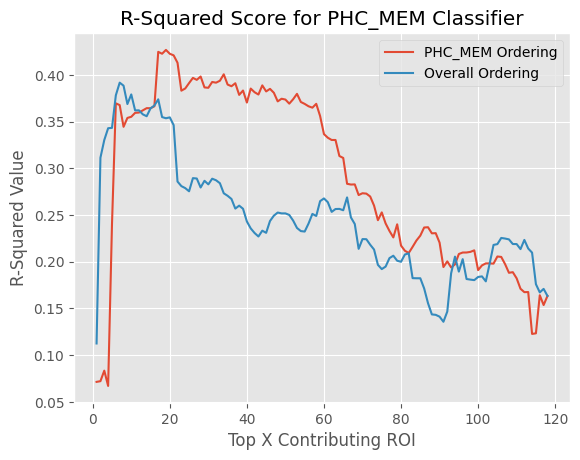

18
0.4266242707128849
6
0.39158042822211137


In [ ]:
# MEM PHC Classifier
import pandas
from sklearn import linear_model, metrics

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_mem_m = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  mem_regr = linear_model.LinearRegression()
  mem_regr.fit(df_classifier_train[fs_mem[0:i+1] + vols_mem[0:i+1]], df_classifier_train[target_cols[0]])
  prediction = mem_regr.predict(df_classifier_test[fs_mem[0:i+1] + vols_mem[0:i+1]])
  r2_arr_mem_m[i] = metrics.r2_score(df_classifier_test[target_cols[0]].to_numpy(), prediction)

r2_arr_mem_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  mem_regr = linear_model.LinearRegression()
  mem_regr.fit(df_classifier_train[fs_overall[0:i+1] + vols_overall[0:i+1]], df_classifier_train[target_cols[0]])
  prediction = mem_regr.predict(df_classifier_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  r2_arr_mem_o[i] = metrics.r2_score(df_classifier_test[target_cols[0]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_mem_m, label = "PHC_MEM Ordering")
plt.plot(list(range(1, 119)), r2_arr_mem_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_MEM Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_mem_m.argmax())
print(r2_arr_mem_m.max())
print(r2_arr_mem_o.argmax())
print(r2_arr_mem_o.max())

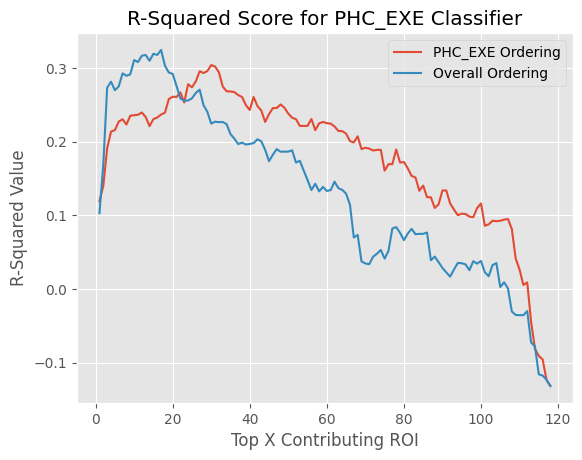

29
0.3040684693580584
16
0.32461692258671837


In [ ]:
# EXF PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_exf_e = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  exf_regr = linear_model.LinearRegression()
  exf_regr.fit(df_classifier_train[fs_exf[0:i+1] + vols_exf[0:i+1]], df_classifier_train[target_cols[1]])
  prediction = exf_regr.predict(df_classifier_test[fs_exf[0:i+1] + vols_exf[0:i+1]])
  r2_arr_exf_e[i] = metrics.r2_score(df_classifier_test[target_cols[1]].to_numpy(), prediction)

r2_arr_exf_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  exf_regr = linear_model.LinearRegression()
  exf_regr.fit(df_classifier_train[fs_overall[0:i+1]+vols_overall[0:i+1]], df_classifier_train[target_cols[1]])
  prediction = exf_regr.predict(df_classifier_test[fs_overall[0:i+1]+vols_overall[0:i+1]])
  r2_arr_exf_o[i] = metrics.r2_score(df_classifier_test[target_cols[1]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_exf_e, label = "PHC_EXE Ordering")
plt.plot(list(range(1, 119)), r2_arr_exf_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_EXE Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_exf_e.argmax())
print(r2_arr_exf_e.max())
print(r2_arr_exf_o.argmax())
print(r2_arr_exf_o.max())

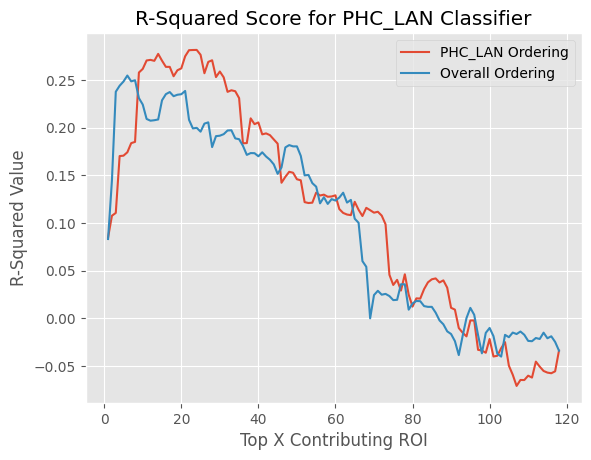

23
0.28134268831058673
5
0.25448442895827406


In [ ]:
# LAN PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_lan_l = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  lan_regr = linear_model.LinearRegression()
  lan_regr.fit(df_classifier_train[fs_lan[0:i+1] + vols_lan[0:i+1]], df_classifier_train[target_cols[2]])
  prediction = lan_regr.predict(df_classifier_test[fs_lan[0:i+1]+vols_lan[0:i+1]])
  r2_arr_lan_l[i] = metrics.r2_score(df_classifier_test[target_cols[2]].to_numpy(), prediction)

r2_arr_lan_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  lan_regr = linear_model.LinearRegression()
  lan_regr.fit(df_classifier_train[fs_overall[0:i+1]+vols_overall[0:i+1]], df_classifier_train[target_cols[2]])
  prediction = lan_regr.predict(df_classifier_test[fs_overall[0:i+1]+vols_overall[0:i+1]])
  r2_arr_lan_o[i] = metrics.r2_score(df_classifier_test[target_cols[2]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_lan_l, label = "PHC_LAN Ordering")
plt.plot(list(range(1, 119)), r2_arr_lan_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_LAN Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_lan_l.argmax())
print(r2_arr_lan_l.max())
print(r2_arr_lan_o.argmax())
print(r2_arr_lan_o.max())

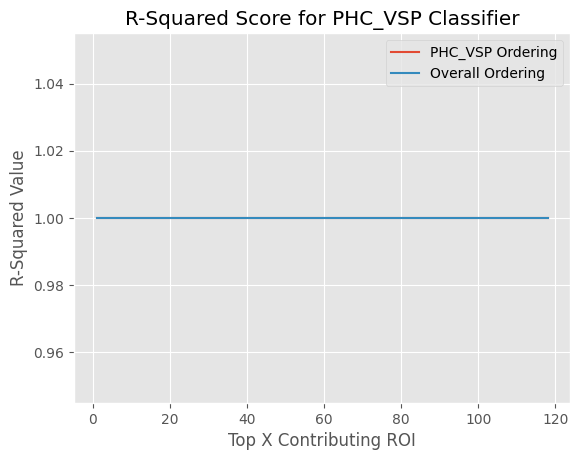

0
1.0
0
1.0


In [ ]:
# VSP PHC Classifier

# print(df_classifier_test[target_cols[0]].to_numpy())
r2_arr_vsp_v = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  vsp_regr = linear_model.LinearRegression()
  vsp_regr.fit(df_classifier_train[fs_vsp[0:i+1] + vols_vsp[0:i+1]], df_classifier_train[target_cols[3]])
  prediction = vsp_regr.predict(df_classifier_test[fs_vsp[0:i+1] + vols_vsp[0:i+1]])
  r2_arr_vsp_v[i] = metrics.r2_score(df_classifier_test[target_cols[3]].to_numpy(), prediction)

r2_arr_vsp_o = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  vsp_regr = linear_model.LinearRegression()
  vsp_regr.fit(df_classifier_train[fs_overall[0:i+1] + vols_overall[0:i+1]], df_classifier_train[target_cols[3]])
  prediction = vsp_regr.predict(df_classifier_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  r2_arr_vsp_o[i] = metrics.r2_score(df_classifier_test[target_cols[3]].to_numpy(), prediction)
plt.plot(list(range(1, 119)), r2_arr_vsp_v, label = "PHC_VSP Ordering")
plt.plot(list(range(1, 119)), r2_arr_vsp_o, label = "Overall Ordering")
plt.title("R-Squared Score for PHC_VSP Classifier")
plt.xlabel('Top X Contributing ROI')
plt.ylabel('R-Squared Value')
plt.legend()
plt.show()
print(r2_arr_vsp_v.argmax())
print(r2_arr_vsp_v.max())
print(r2_arr_vsp_o.argmax())
print(r2_arr_vsp_o.max())

# CN/MCI-AD Classifier

In [ ]:
cognitionDF = pd.concat([df_nn[df_nn['dx_current.tau'] == 'CN'], df_nn[df_nn['dx_current.tau'] == 'MCI-AD']])
cognitionDF['dx_current.tau'].replace('CN', 0, inplace=True)
cognitionDF['dx_current.tau'].replace('MCI-AD', 1, inplace=True)
cognitionDF_train = cognitionDF.sample(frac=0.8)
cognitionDF_test = cognitionDF.drop(cognitionDF_train.index)

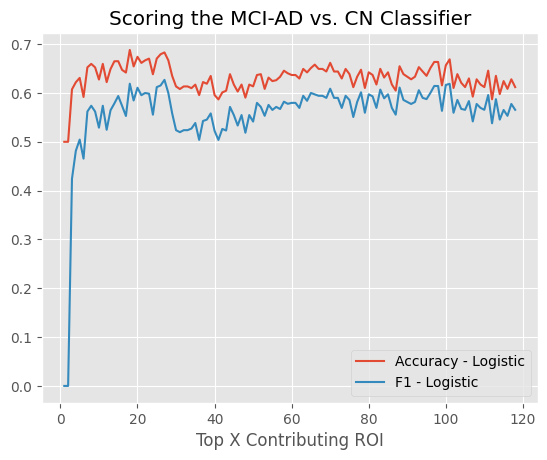

17
0.688145896656535
26
0.626865671641791


In [ ]:
import pandas
from sklearn import linear_model, metrics

f1_cognitionLog = np.zeros(len(feature_cols))
accuracy_cognitionLog = np.zeros(len(feature_cols))
for i in range(len(feature_cols)):
  cogntion_regr = linear_model.LogisticRegression()
  cogntion_regr.fit(cognitionDF_train[fs_overall[0:i+1] + vols_overall[0:i+1]], cognitionDF_train['dx_current.tau'])
  prediction = cogntion_regr.predict(cognitionDF_test[fs_overall[0:i+1] + vols_overall[0:i+1]])
  # print('Prediction:')
  # print(prediction)
  # print('Truth:')
  # print(cognitionDF_test['dx_current.tau'].to_numpy())
  f1_cognitionLog[i] = metrics.f1_score(cognitionDF_test['dx_current.tau'].to_numpy(), prediction)
  accuracy_cognitionLog[i] = metrics.balanced_accuracy_score(cognitionDF_test['dx_current.tau'].to_numpy(), prediction)
plt.plot(list(range(1, 119)), accuracy_cognitionLog, label="Accuracy - Logistic")
plt.plot(list(range(1, 119)), f1_cognitionLog, label="F1 - Logistic")
plt.title("Scoring the MCI-AD vs. CN Classifier")
plt.xlabel('Top X Contributing ROI')
plt.legend()
plt.show()
print(accuracy_cognitionLog.argmax())
print(accuracy_cognitionLog.max())
print(f1_cognitionLog.argmax())
print(f1_cognitionLog.max())